캐글 SeaOtter, BLUEPINETREE 님의 커널을 참고하였습니다.

회고

1. 다양한 데이터 특징에 대한 깊은 탐색을 할 수 있었습니다.
2. 이상치 처리에 대해 다방면으로 확인해 보고 결정, 제거하는 방법을 학습할 수 있었습니다.
3. 다양한 그래프를 한번씩 사용해 볼 수 있었습니다.
4. 같은 라이브러리를 임포트해도 오류가 날 수 있고 해결하는 방법을 학습할 수 있었습니다.

In [2]:
# Loding packages
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import gc
import warnings
warnings.filterwarnings("ignore")

print('얍💢')


얍💢


In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [4]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)
print(train.shape)    # 훈련데이터, 시험데이터 크기는 각각 15035, 6468로 비율이 5:2로 심하게 불균등하지는 않습니다
print(test.shape)     # 변수의 갯수가 20개로 적은 편이어서 좋은 피쳐를 만들어내는 것이 모델 성능에 관건으로 생각됩니다.

(15035, 21)
(6468, 20)


In [5]:
train.head()

# date의 경우 T000000는 제거해주겠습니다
# yr_renovated의 경우 0의 값이 보이는데, 0년도에 건축되었다는 의미가 아니라 재건축을 하지 않았다는 의미입니다.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

1.3 변수 시각화(목적 변수)

In [7]:
# describe statistics summery
train['price'].describe()  # 목적 변수의 경우 최솟값(min)과 최댓값(max)의 차이가 크고, 표준 편차(std)가 굉장히 큰 편입니다.

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

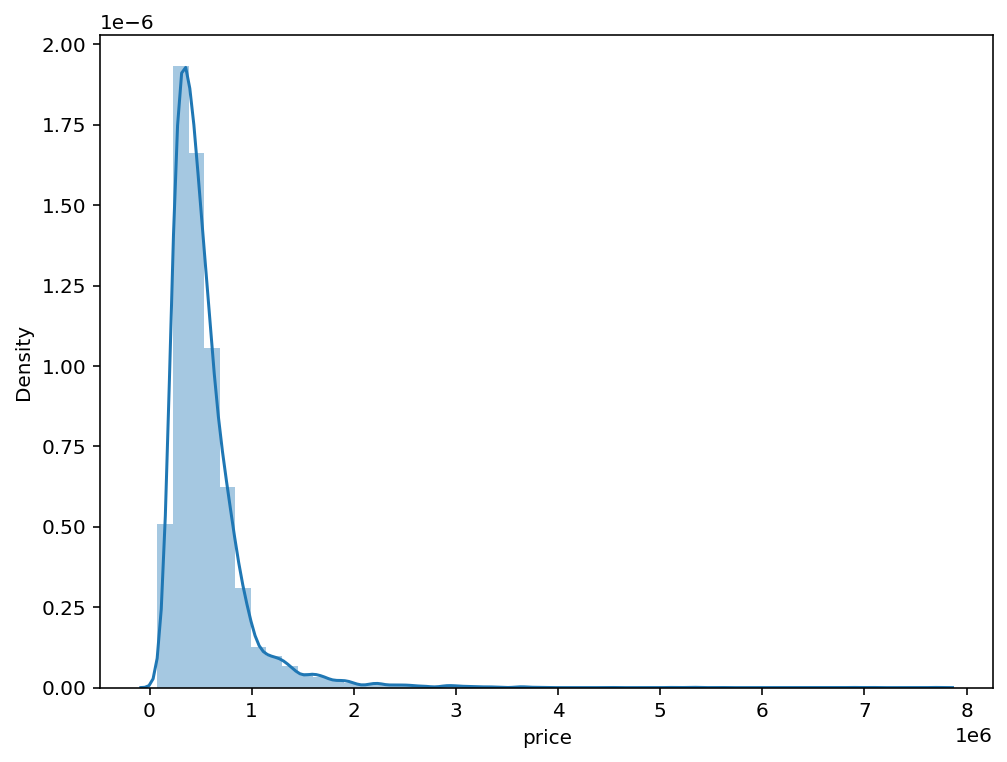

In [8]:
# histogram
plt.figure(figsize=(8,6))
sns.distplot(a=train['price'])  # 가격이 낮은 쪽에 굉장히 치우친 것을 확인이 가능합니다.

In [9]:
# skewness and krutosis
print('Skewness:', train['price'].skew())
print('Kurtosis:', train['price'].kurt())

Skewness: 4.290252396939529
Kurtosis: 40.15491919350329


왜도(skewness) : 데이터 분포가 얼마나 치우쳤는지 보여주는 척도로서, 왼쪽으로 꼬리가 길수록 음수 방향으로 값이 커지고, 오른쪽으로 꼬리가 길수록 양수 방향으로 값이 커진다.

첨도(kurtosis) : 데이터 분포가 분포 가운데에 얼마나 몰려있는지 보여주는 척도로서, 첨도 값(K)이 3에 가까울 경우 그래프는 정규분포에 가깝고, (K<3)이면 정규분포보다 더 평탄하다고 판단할 수 있으며, (K>3)인 경우 정규분포보다 더 뾰족한 분포로 간주 할 수 있다.

위의 목적 변수의 경우 정규분포를 따르지 않고 분산 또한 매우 큰것을 확인할 수 있습니다. 회귀 모델 사용을 위해 정규화(Normalize)를 통해 price의 분포가 정규분포에 가깝도록 가공해 주겠습니다.

((array([-3.91024552, -3.69050911, -3.57011438, ...,  3.57011438,
          3.69050911,  3.91024552]),
  array([11.26447693, 11.28979441, 11.30221678, ..., 15.74485584,
         15.7703098 , 15.85673102])),
 (0.5246386762816583, 13.04812230186611, 0.9944175231748045))

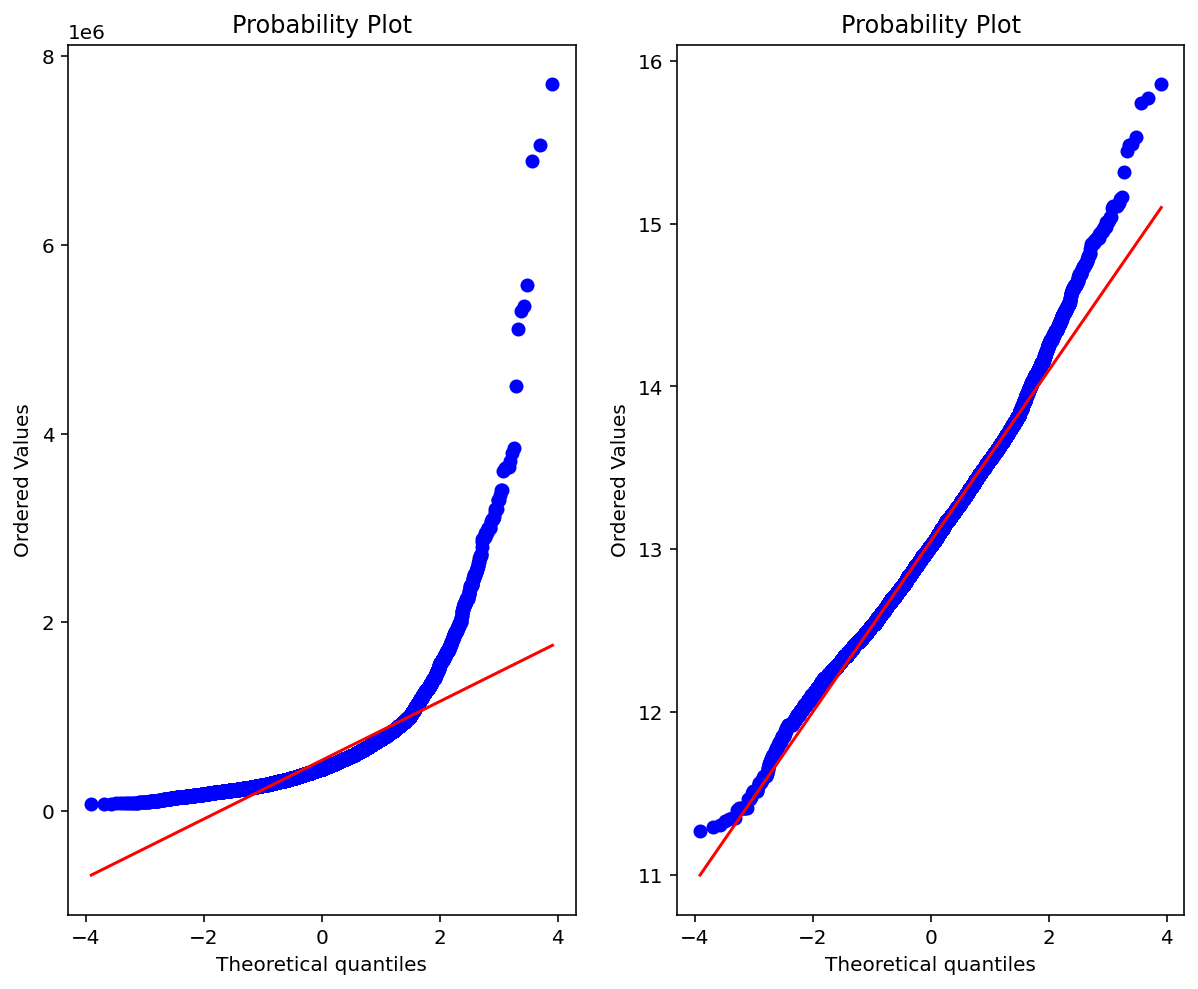

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,8)
stats.probplot(x=train['price'], plot=axes[0])
stats.probplot(x=np.log1p(train['price']), plot=axes[1])  # log를 취해주면 기존보다 더 정규성을 가지는 것을 확인할 수 있습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

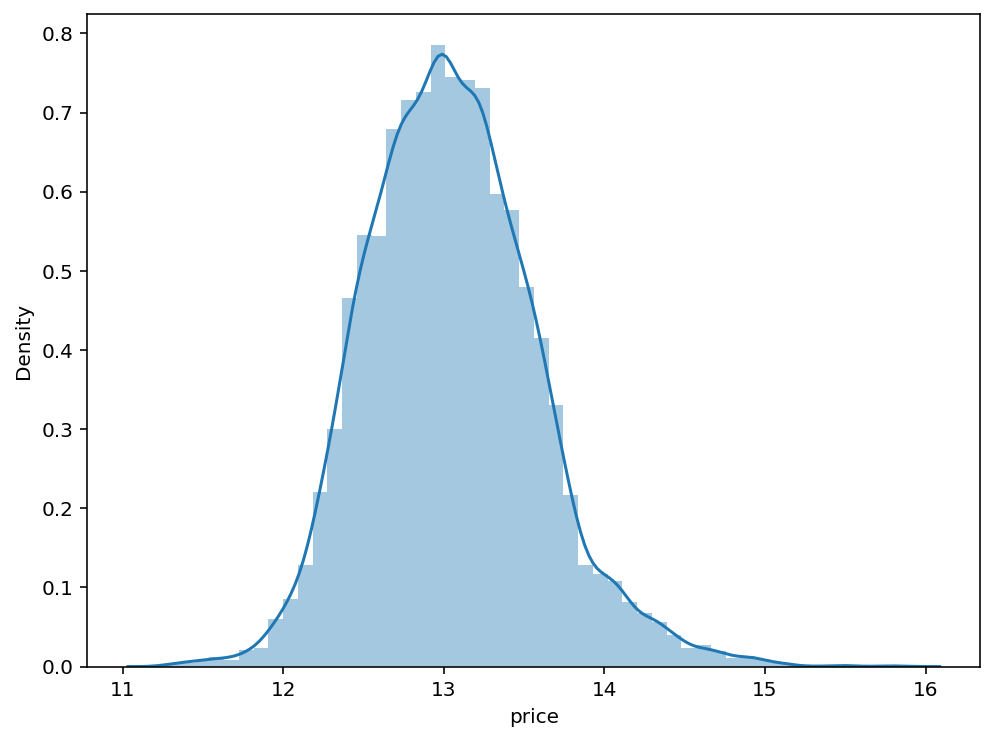

In [11]:
train['price'] = np.log1p(train['price'])
# histogram
plt.figure(figsize=(8,6))
sns.distplot(a=train['price'])  # 정규분포에 가까워 진걸 확인할 수 있습니다

1.3 변수 시각화(반응변수)

- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

아래는 목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다. 
편의를 위해 상관도가 높은 상위 15개의 값만 보도록 하겠습니다.

<AxesSubplot:>

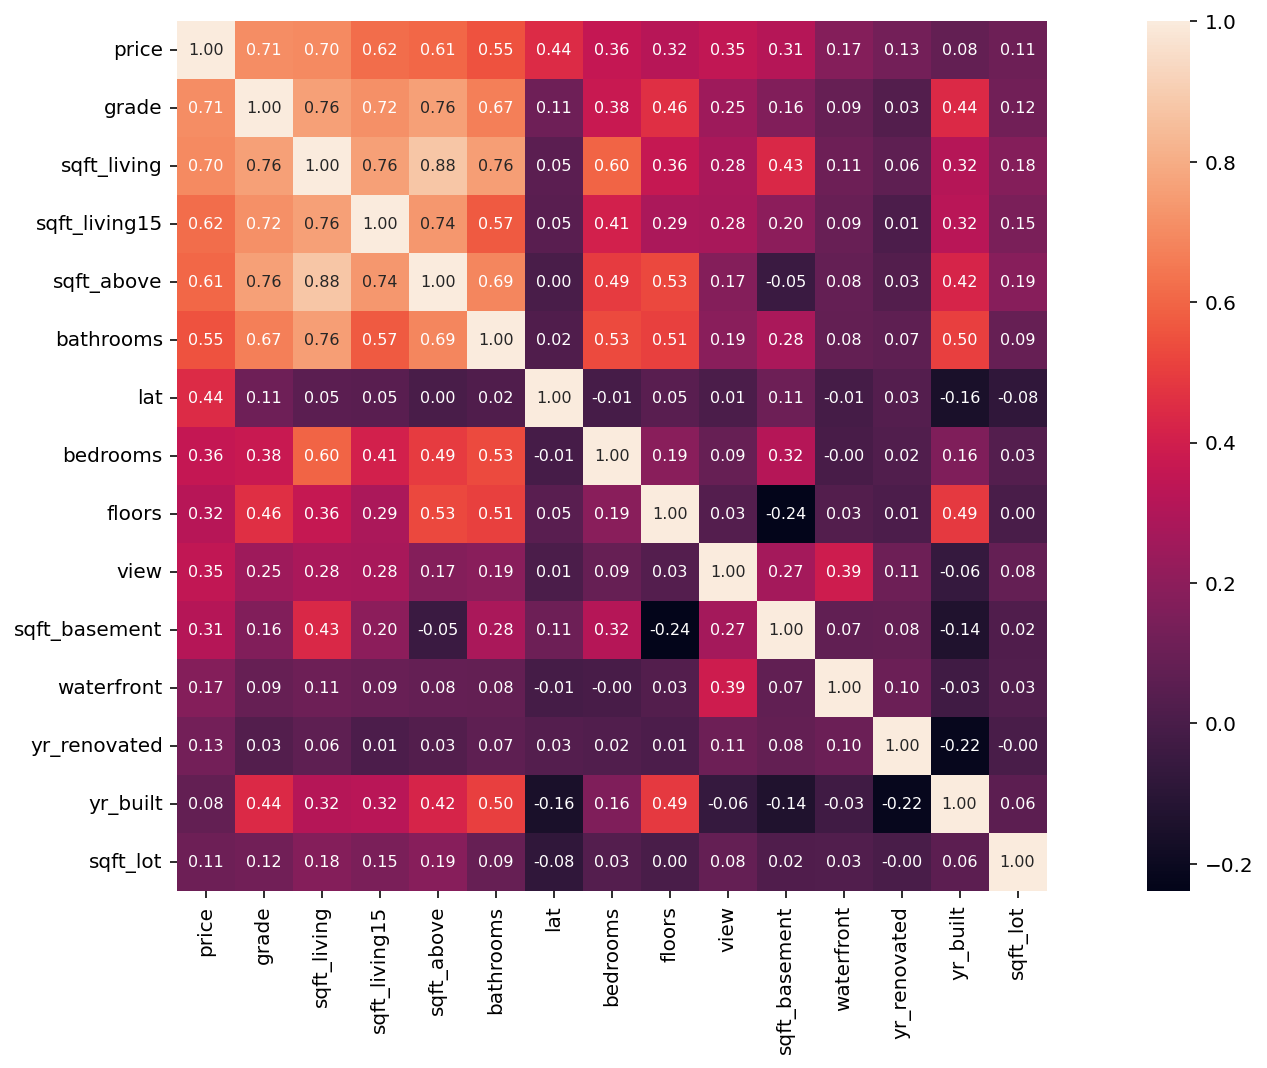

In [12]:
# saleprice correlation matrix
k = 15 # number of variables for heatmap
corrmat = abs(train.corr(method='spearman')) # correlation 전체 변수에 대해서 계산
cols = corrmat.nlargest(k, 'price').index # nlargest : return this many descending sorted values
cm = np.corrcoef(train[cols].values.T) # correlation 특정 칼럼에 대해서

fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(data=cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':8}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)

목적변수와 상관도가 높은 변수는 집의 등급 -> 주거공간의 크기 -> 전체 크기순이고, 위도를 뜻하는 lat라는 값도 들어있습니다. 양의 상관관계인것을 보니 위도가 증가할수록 가격의 값이 증가한다는 뜻인데, 왜 이렇것인지, 어떻게 활용할 수 있을지는 탐구가 필요할 듯 합니다.

- 집의 평수가 넓을수록 등급도 함께 높아지는 경향이 있다.
- 그리고 이 등급은 가격에 큰 영향을 미친다.

<AxesSubplot:xlabel='grade', ylabel='price'>

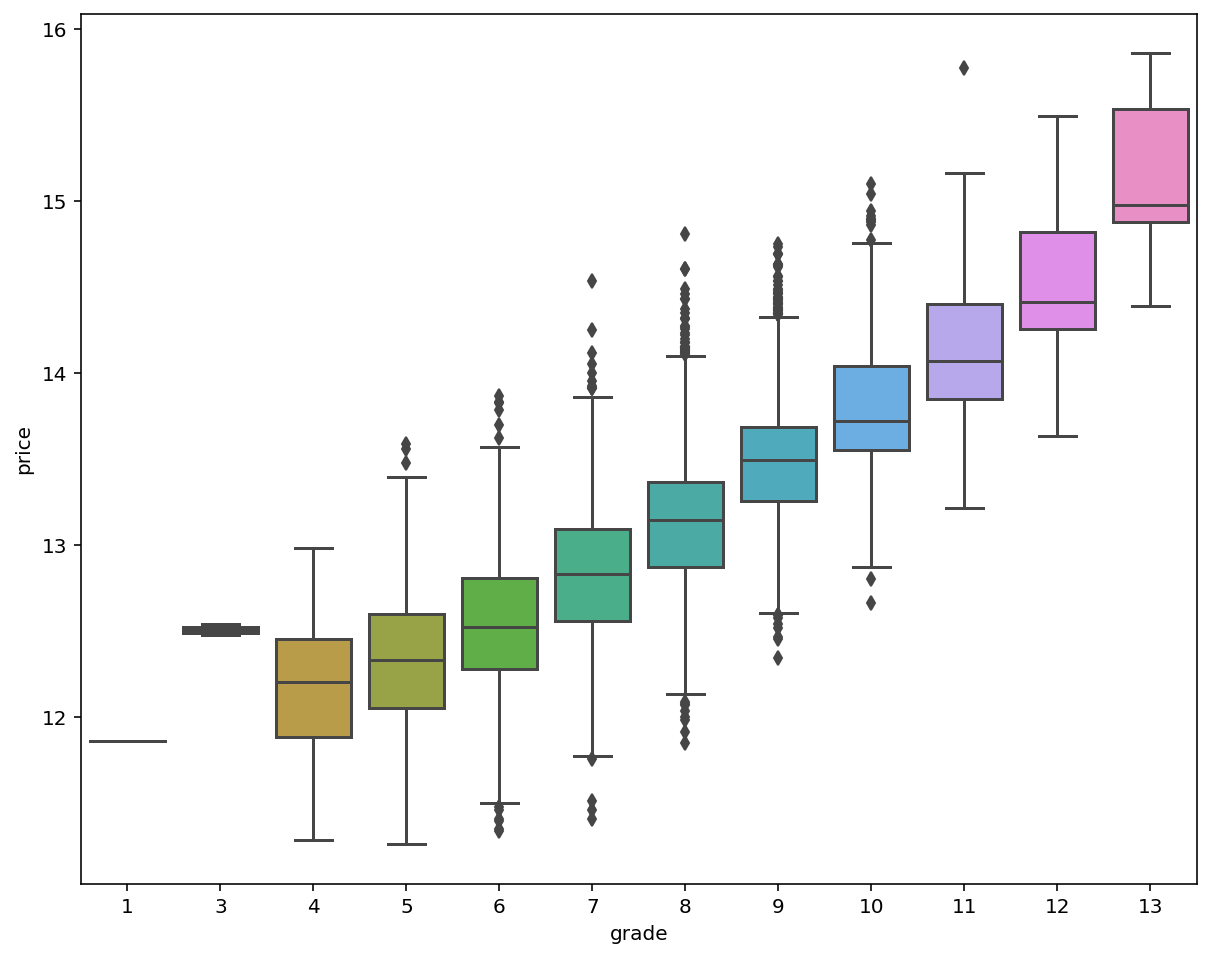

In [13]:
# np.corrcoef(train[cols].values).shape
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=data, x='grade', y='price', ax=ax)

<AxesSubplot:title={'center':'Test set'}, xlabel='grade', ylabel='count'>

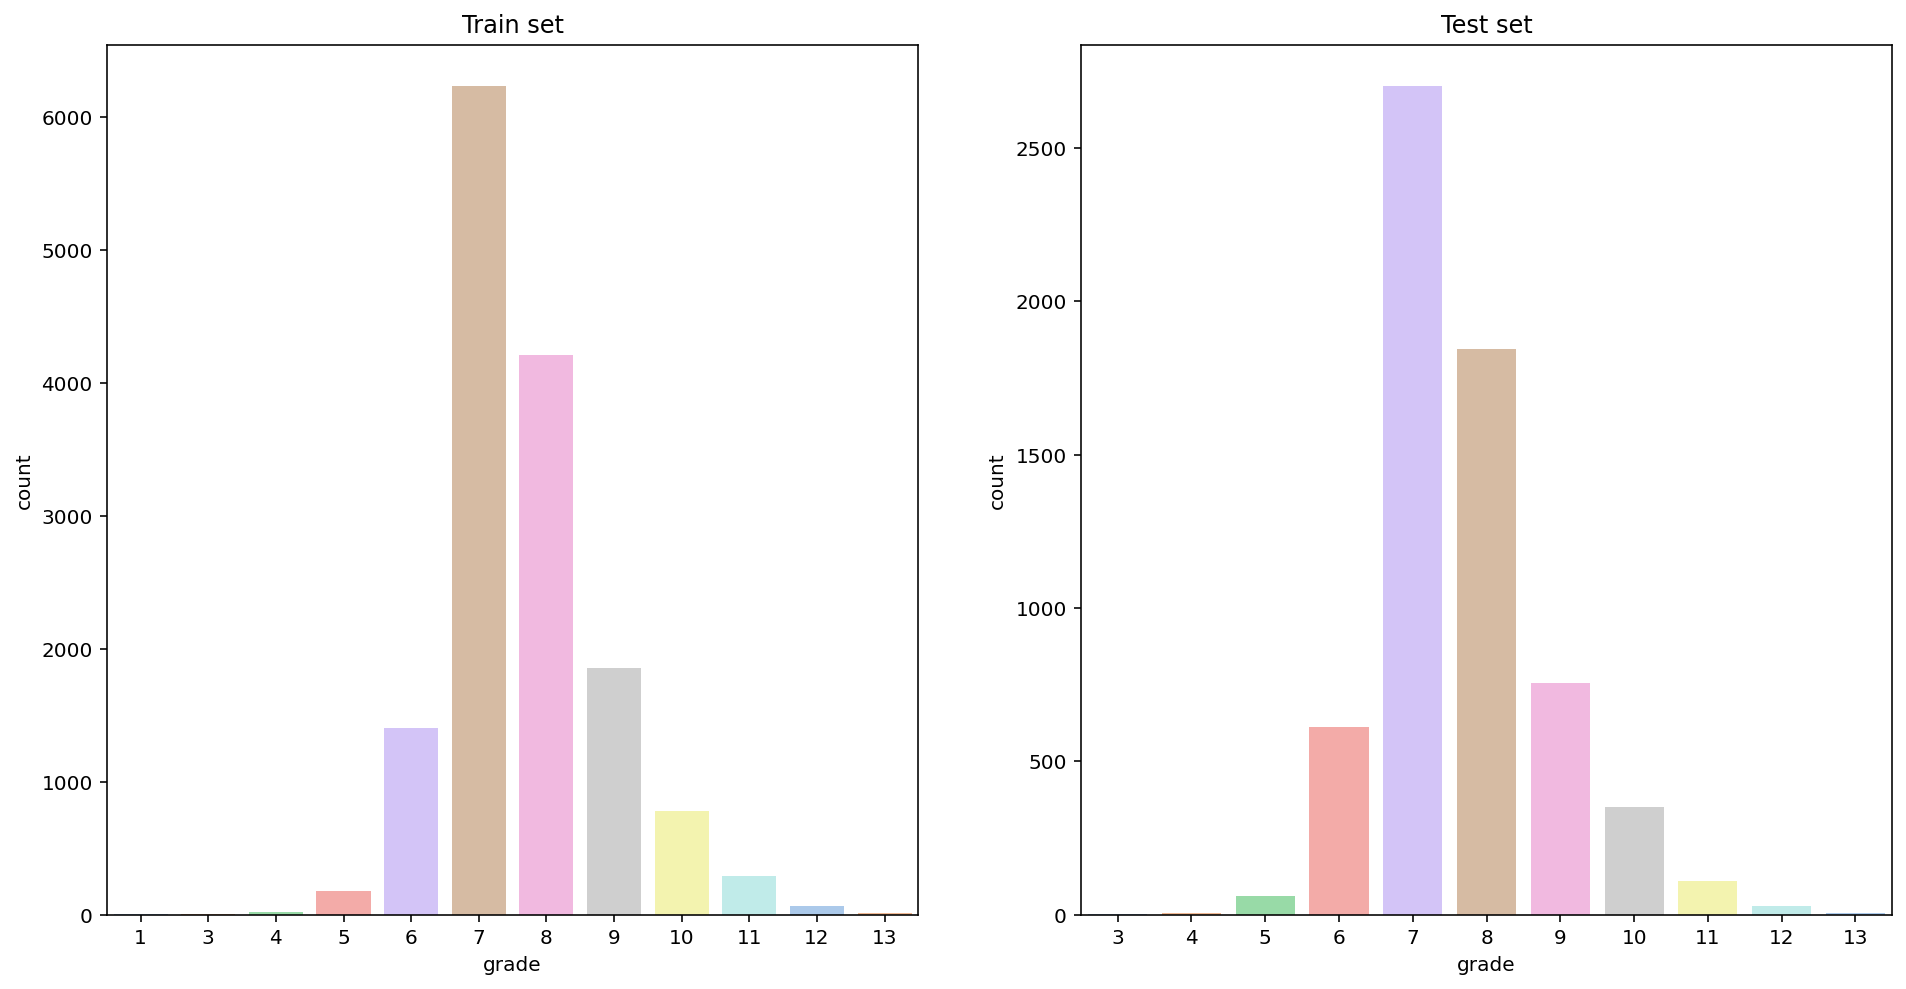

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].set(title='Train set')
sns.countplot(x='grade', data=train, ax=ax[0], palette=sns.color_palette('pastel'))

ax[1].set(title='Test set')
sns.countplot(x='grade', data=test, ax=ax[1], palette=sns.color_palette('pastel'))

집의 등급이 높으면 가격이 높아지는 것은 위의 히트맵에서도 봤듯이 당연한 결과입니다. 그리고 전반적으로 상승곡선 형태도 보이고 있습니다. 하지만

- 등급 6,7,8,9 에서 이상치(outlier)가 많은 이유
- 등급 8과 11에서 차이가 큰 이상치가 나타나는 이유

위의 두가지는 좀 더 살펴볼 여지가 있어보입니다.

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

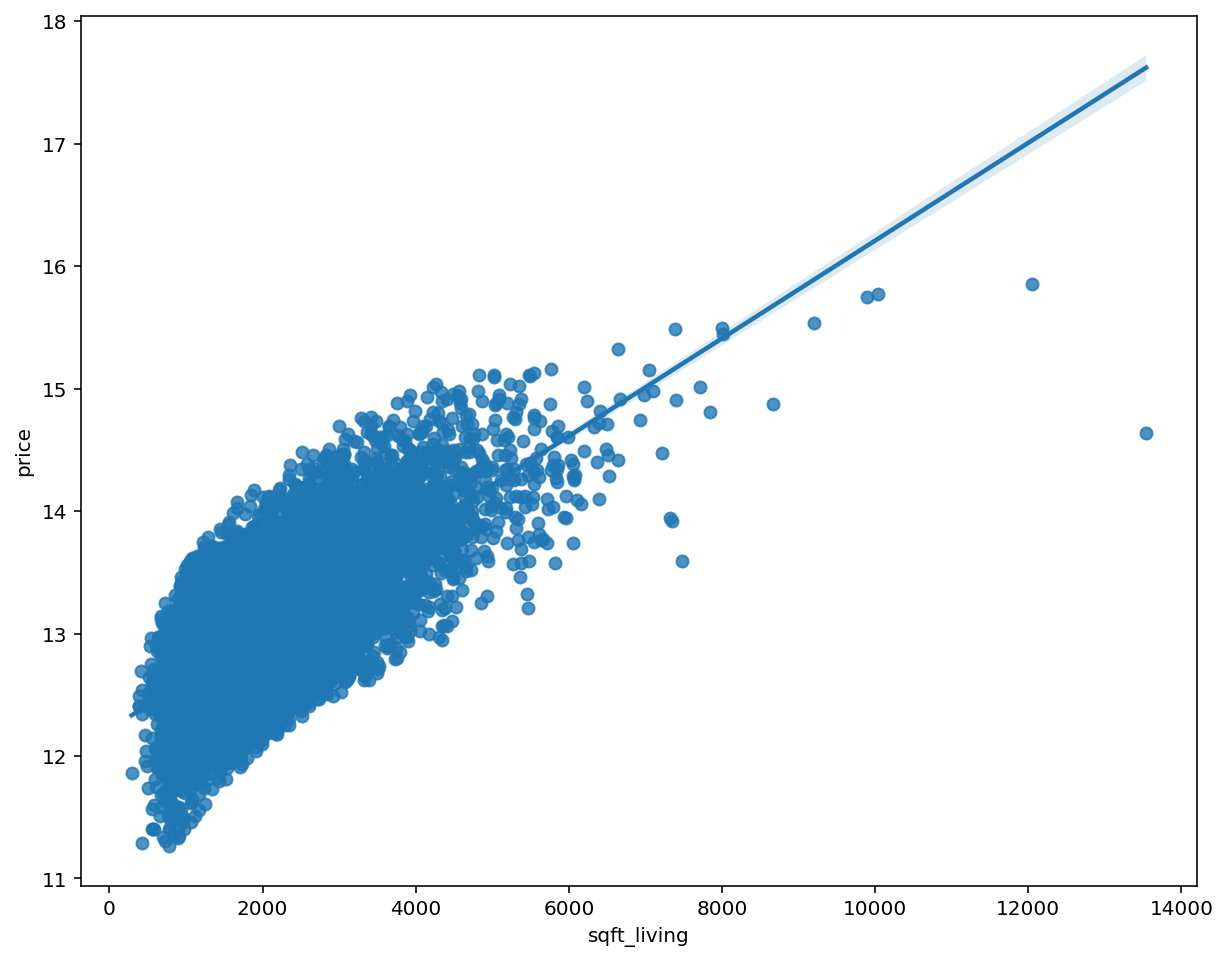

In [15]:
data = pd.concat([train['sqft_living'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='sqft_living', y='price', data=data, ax=ax)

전반적으로 선형성을 보이지만 가격 14~15 사이에 sqft_living이 14000이나 되는 값은 이상한 값(이상치)으로 보입니다. 제거할지 말지는 저 값을 확인해보고 결정해 보도록 하겠습니다.

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

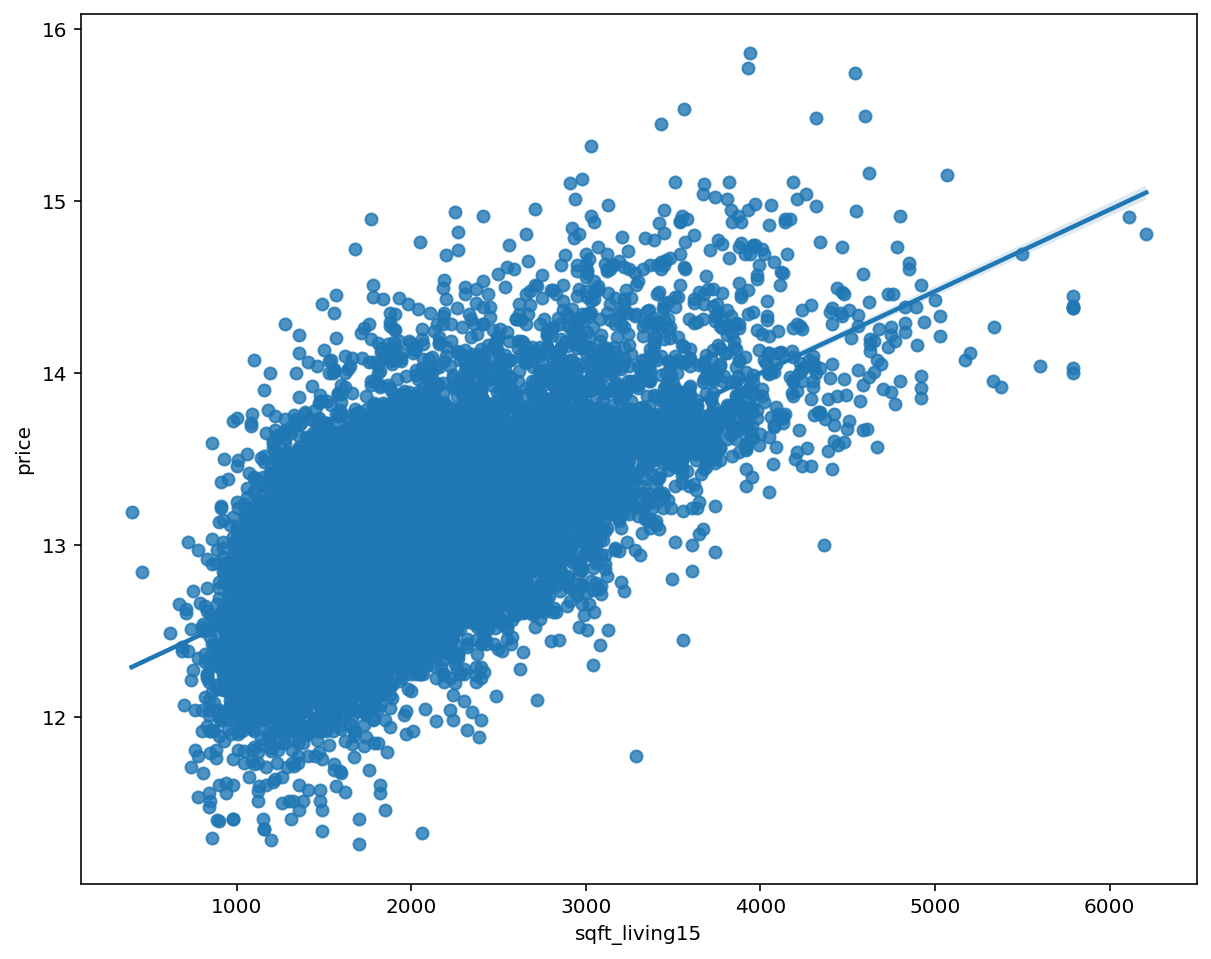

In [16]:
data = pd.concat([train['sqft_living15'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='sqft_living15', y='price', data=data, ax=ax)

<AxesSubplot:xlabel='sqft_living15', ylabel='Density'>

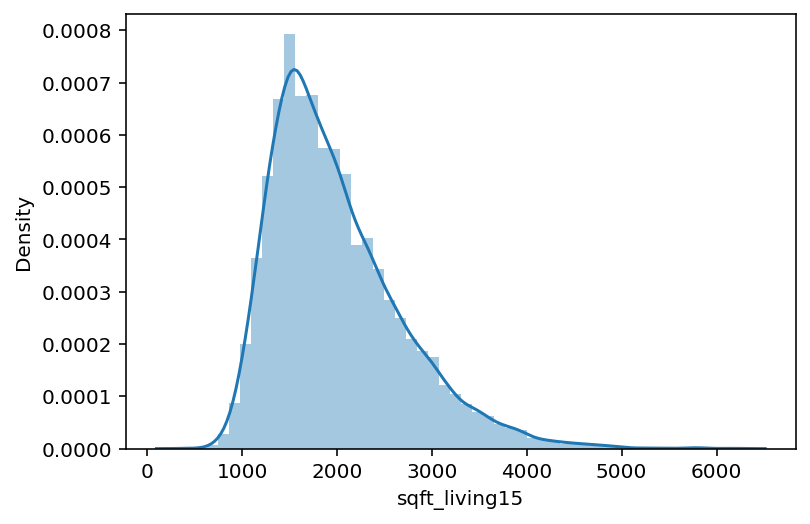

In [17]:
sns.distplot(a=train['sqft_living15'])

sqft_living15의 경우 15년도 기준이다보니 가격의 분산이 비교적 큽니다. 아무래도 재건축으로 인한 영향일것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 Feature Engineering이 필요해 보입니다.

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

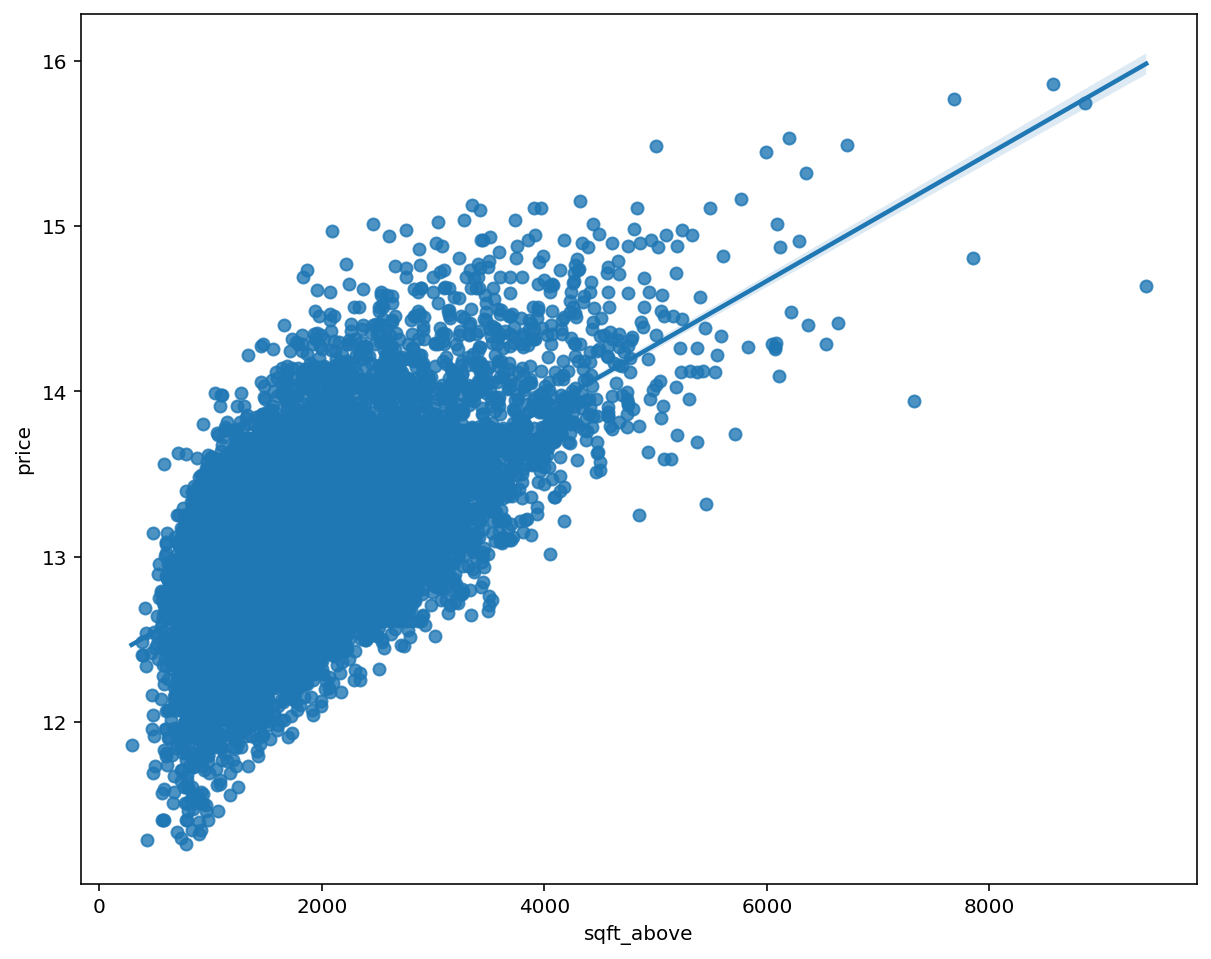

In [18]:
data = pd.concat([train['sqft_above'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='sqft_above', y='price', data=data)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

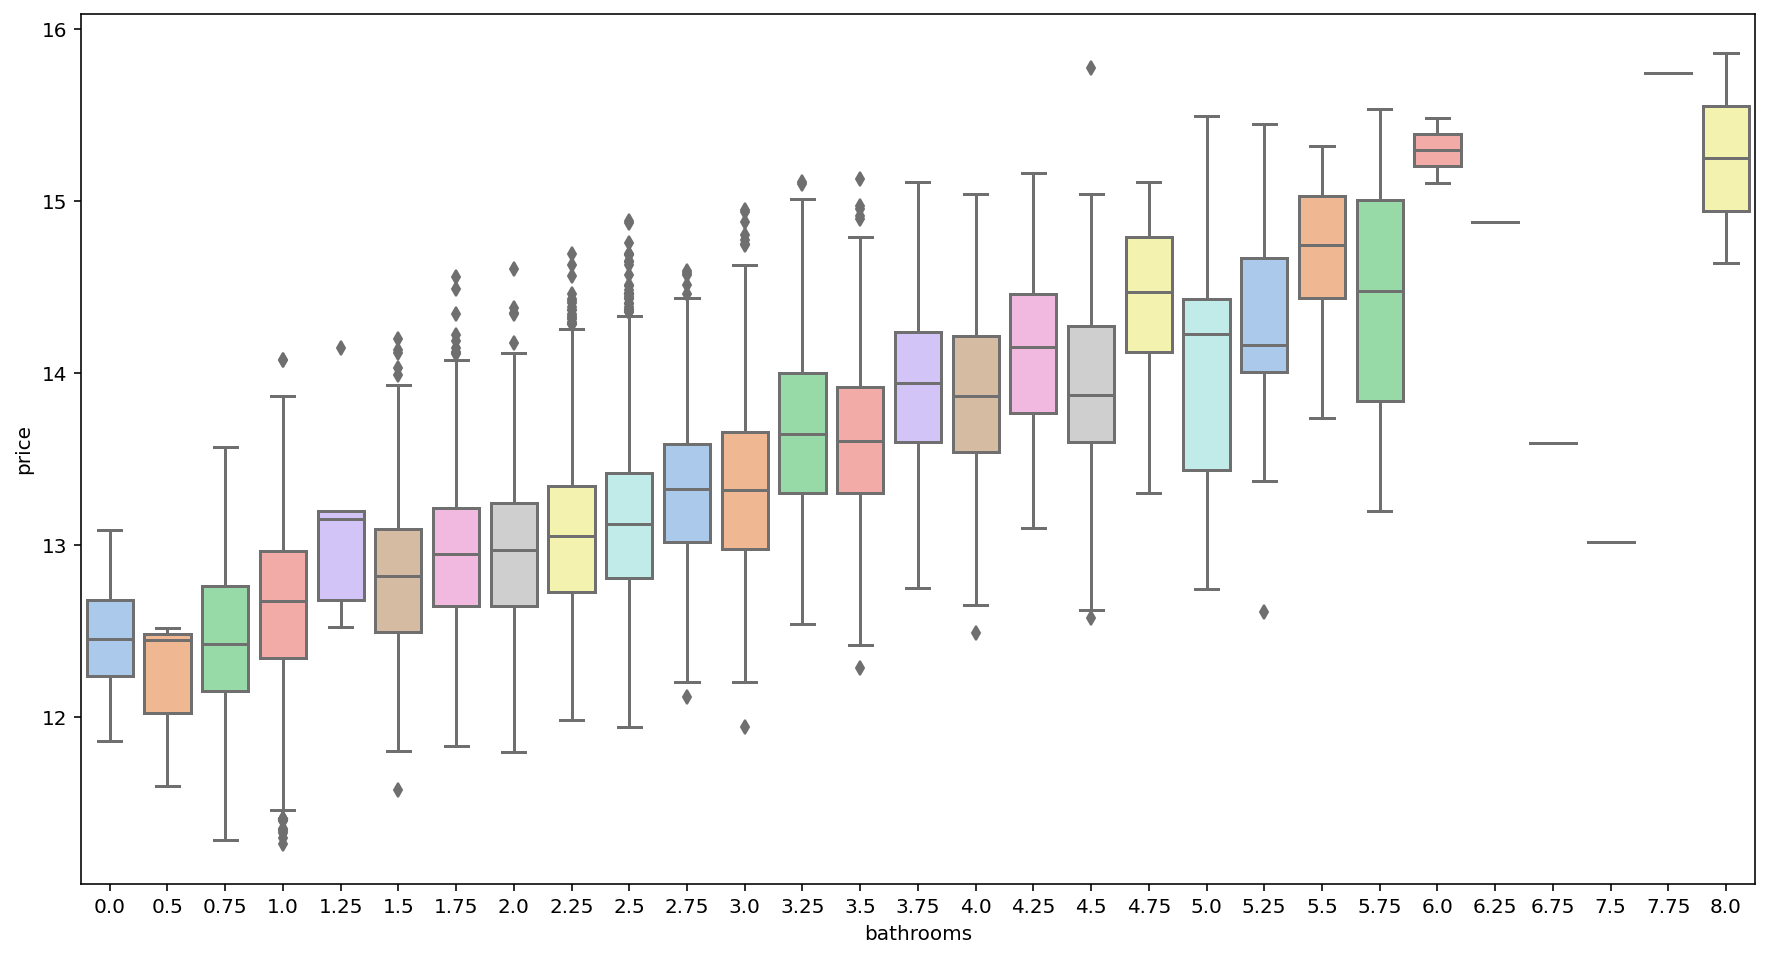

In [19]:
data = pd.concat([train['bathrooms'], train['price']], axis=1)
f, ac = plt.subplots(figsize=(15,8))
sns.boxplot(x='bathrooms', y='price', data=data, palette=sns.color_palette('pastel'))

<AxesSubplot:title={'center':'Test set'}, xlabel='bathrooms', ylabel='count'>

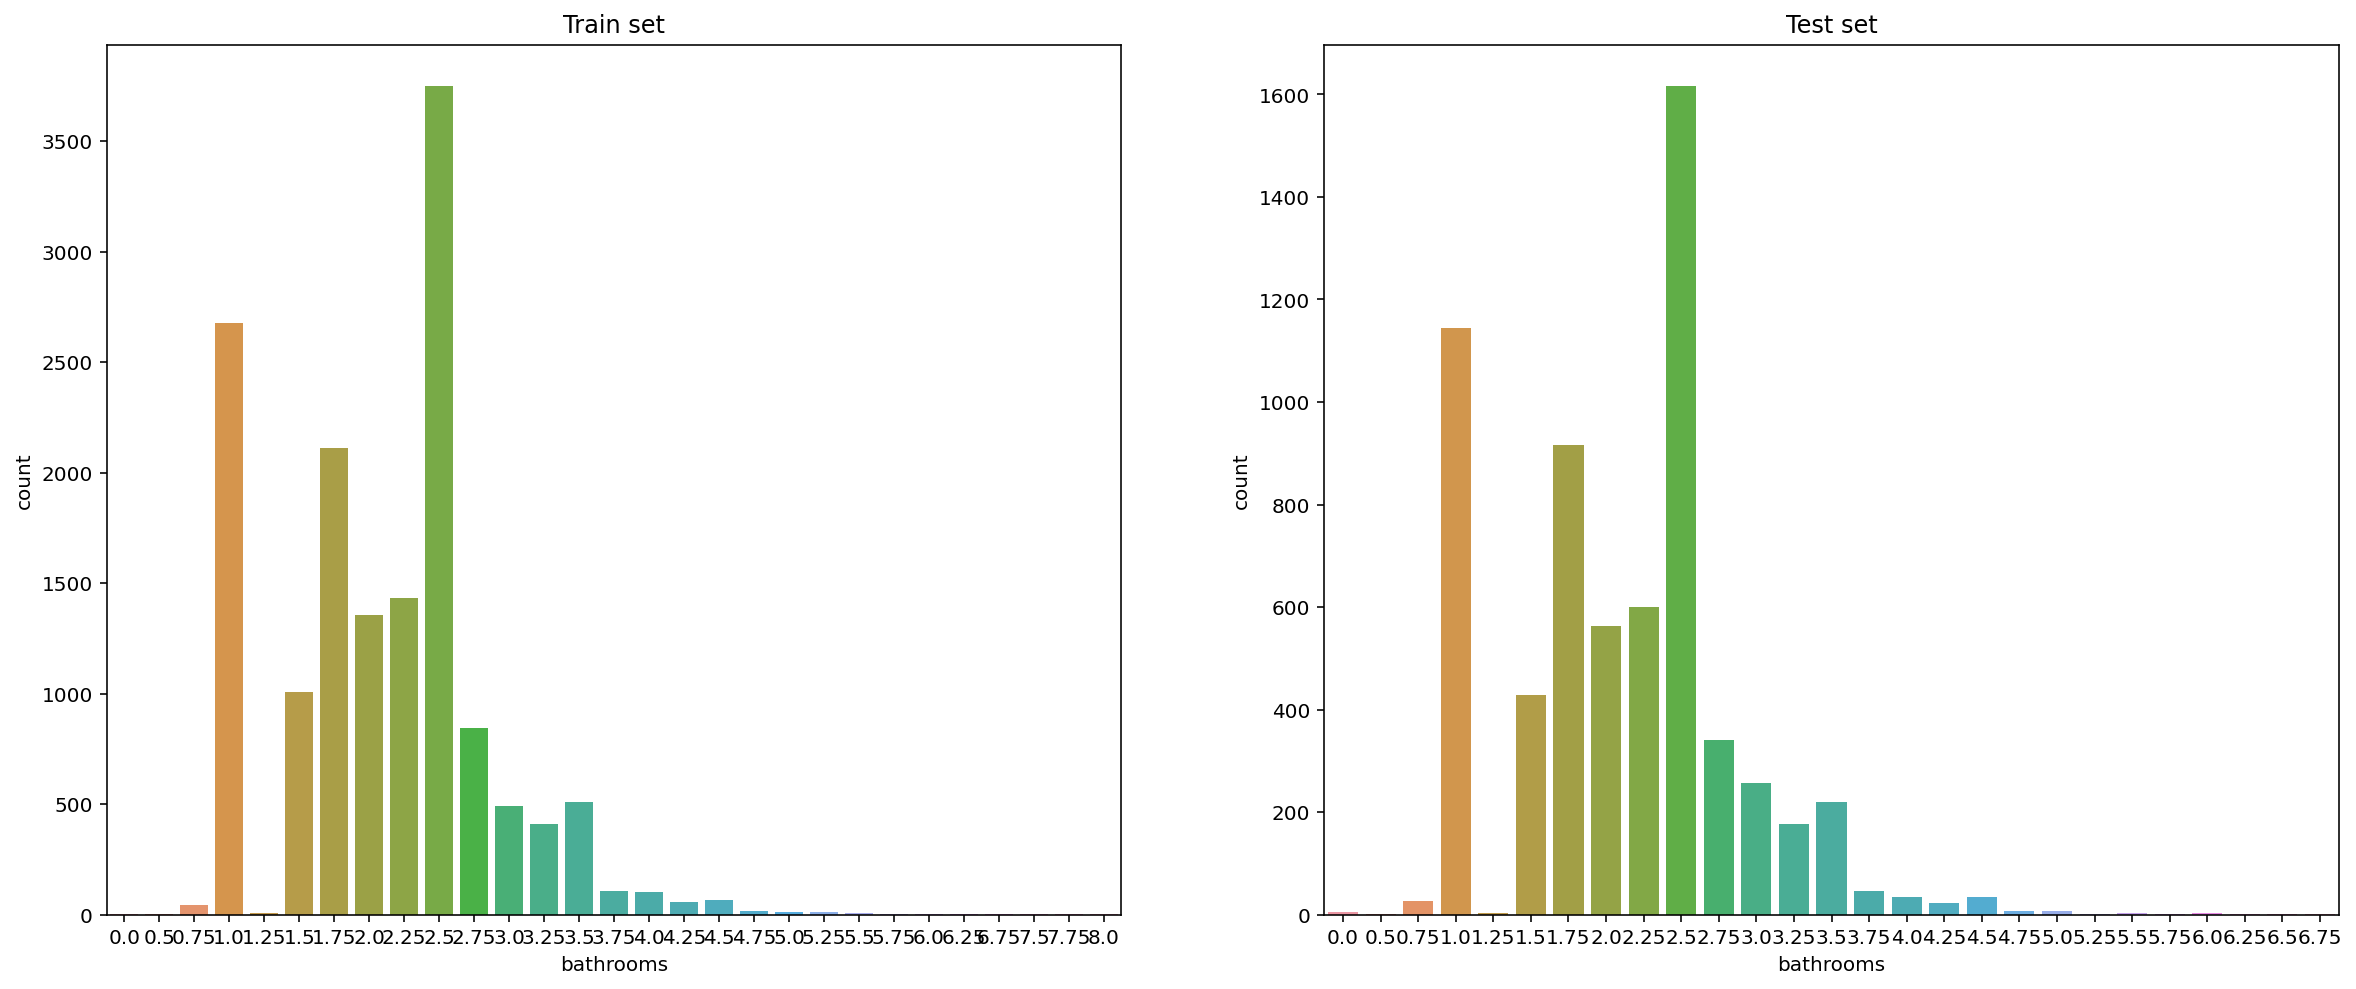

In [20]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
ax[0].set(title='Train set')
sns.countplot(x='bathrooms', data=train, ax=ax[0])

ax[1].set(title='Test set')
sns.countplot(x='bathrooms', data=test, ax=ax[1])

bathrooms 같은 경우 소수점이 있어 헷갈릴 수도 있습니다. 각각의 값이 의미하는 것은 아래와 같고, 위의 값만을 가지고 각각의 값이 몇개 있는지는 구분하기 힘들어 보입니다.

- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

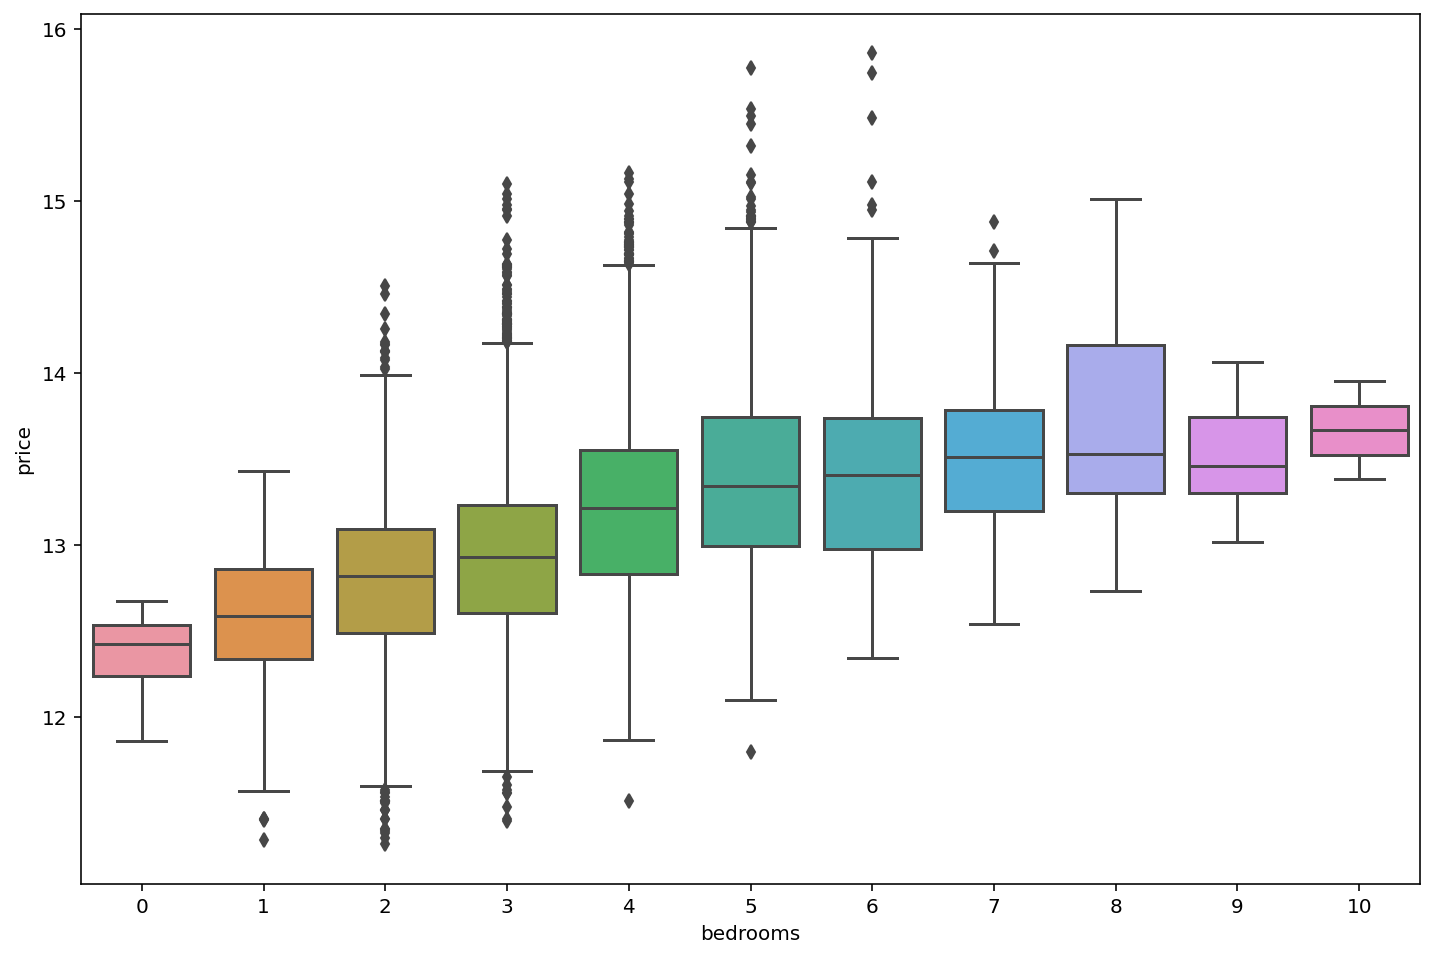

In [21]:
data = pd.concat([train['bedrooms'], train['price']], axis=1)
f, ac = plt.subplots(figsize=(12,8))
sns.boxplot(x='bedrooms', y='price', data=data)

<AxesSubplot:title={'center':'Test set'}, xlabel='bedrooms', ylabel='count'>

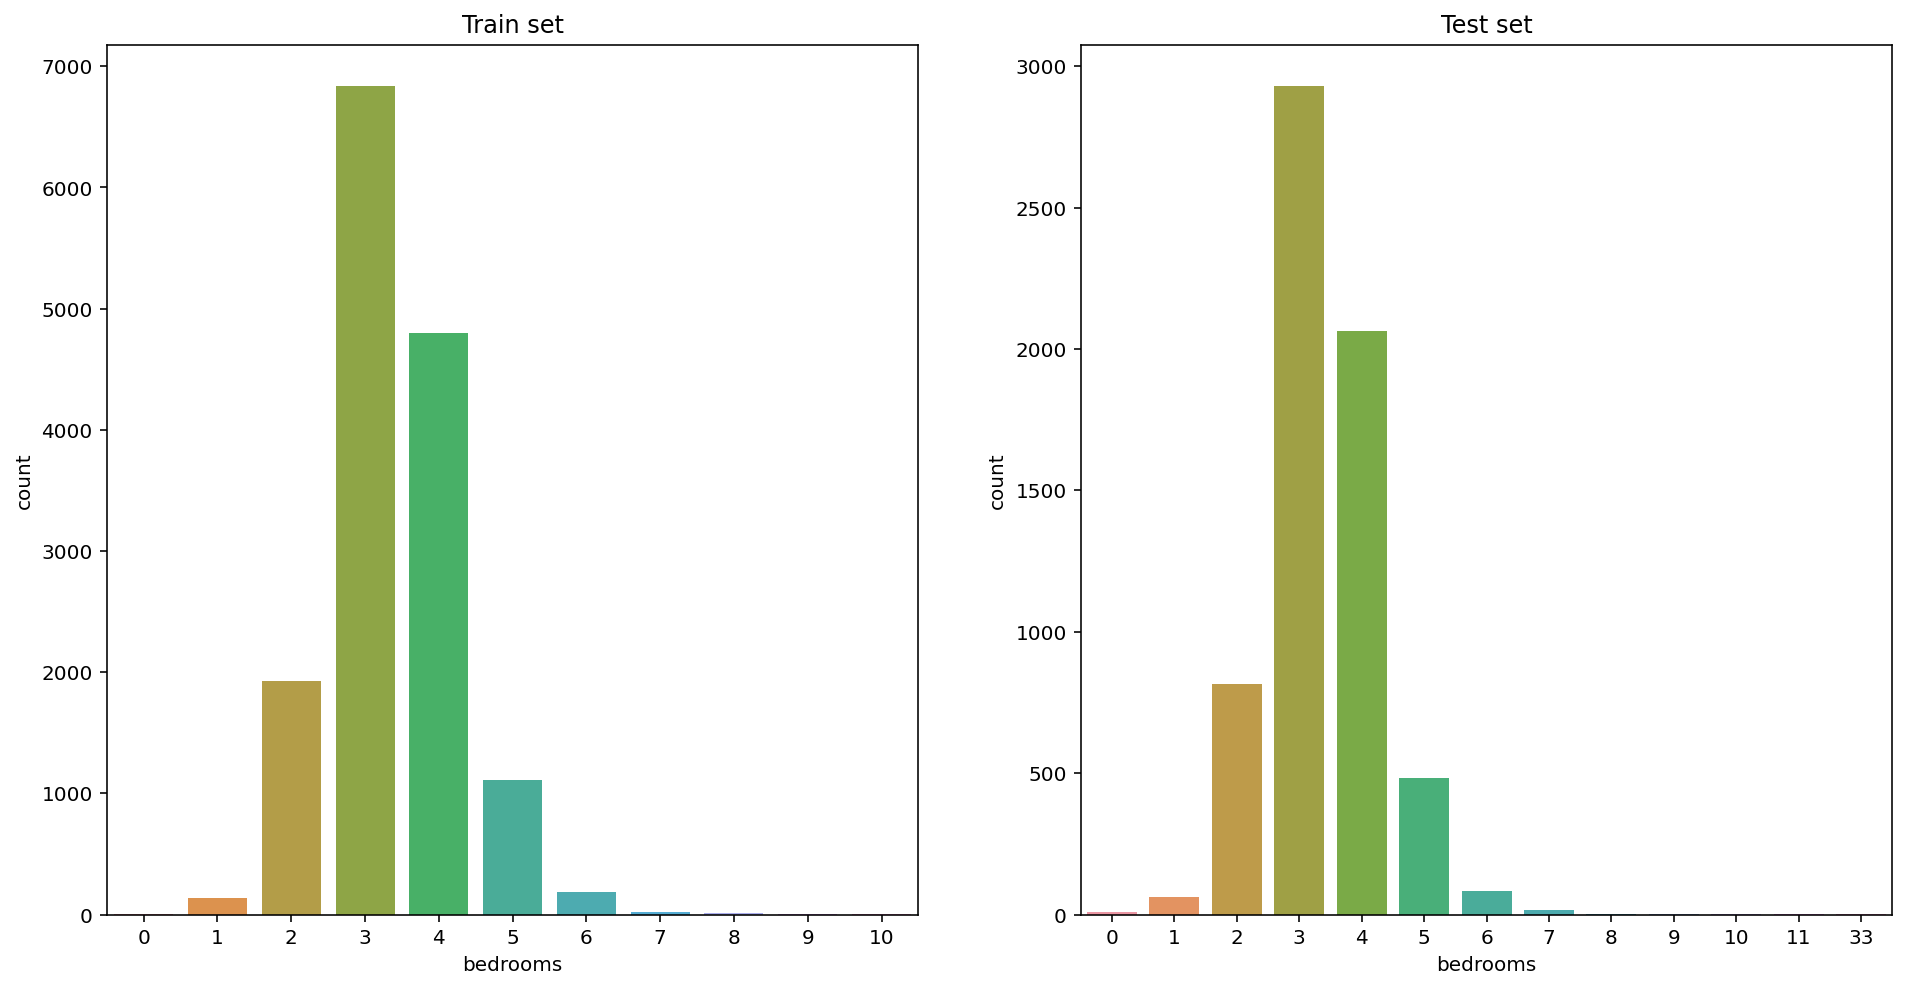

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
ax[0].set(title='Train set')
sns.countplot(x='bedrooms', data=train, ax=ax[0])

ax[1].set(title='Test set')
sns.countplot(x='bedrooms', data=test, ax=ax[1])

독특하게 방 수가 30이 넘는 값들이 있고, price는 비교적 낮은 것 또한 볼 수 있습니다. 이러한 값들은 특정한 이유가 있어서 이렇게 된 것으로 볼 수 있습니다.(ex)숙박시설, 외딴 지역 등).

<AxesSubplot:xlabel='floors', ylabel='price'>

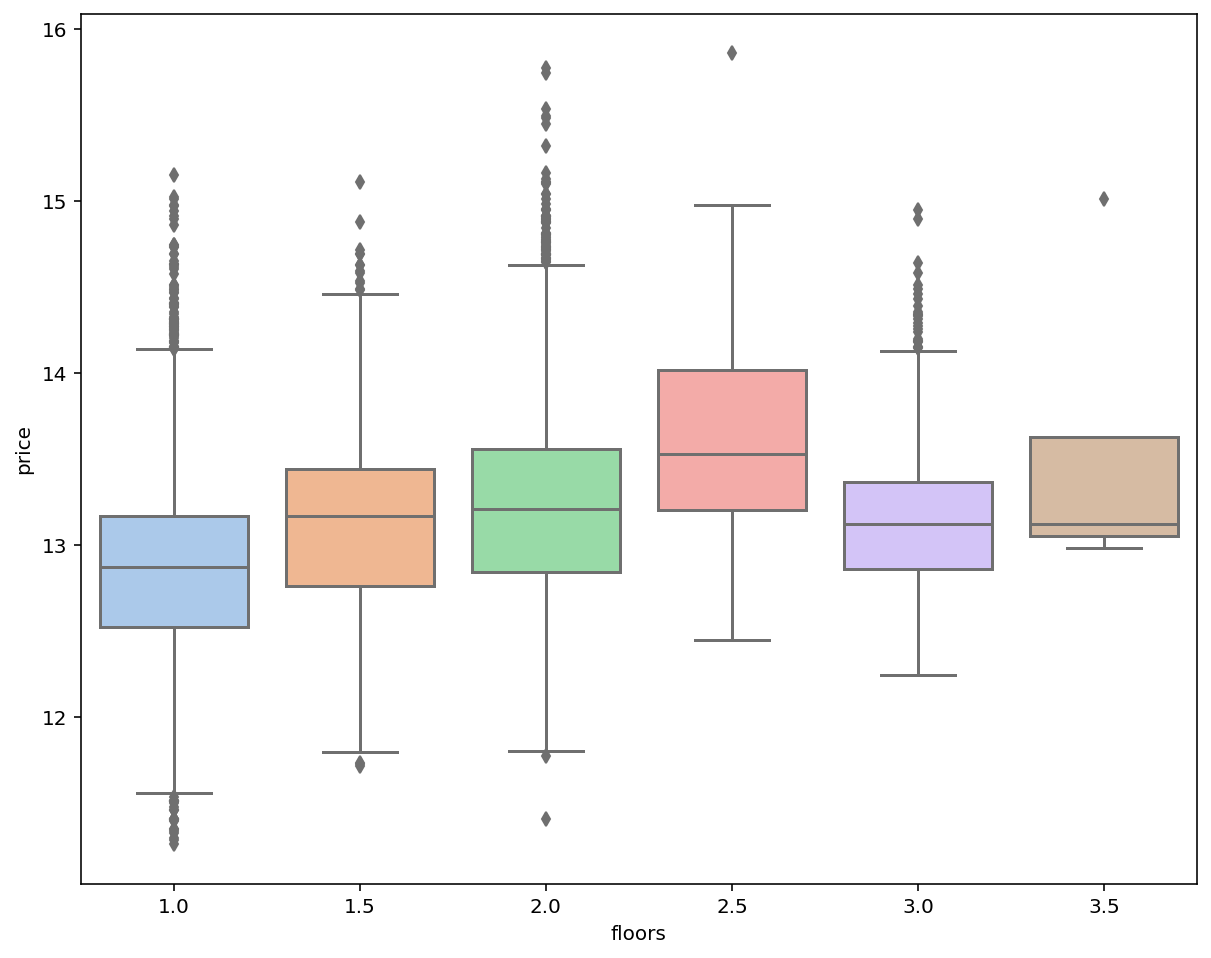

In [23]:
data = pd.concat([train['floors'], train['price']], axis=1)
f, ac = plt.subplots(figsize=(10,8))
sns.boxplot(x='floors', y='price', data=data, palette=sns.color_palette('pastel'))

<AxesSubplot:xlabel='view', ylabel='price'>

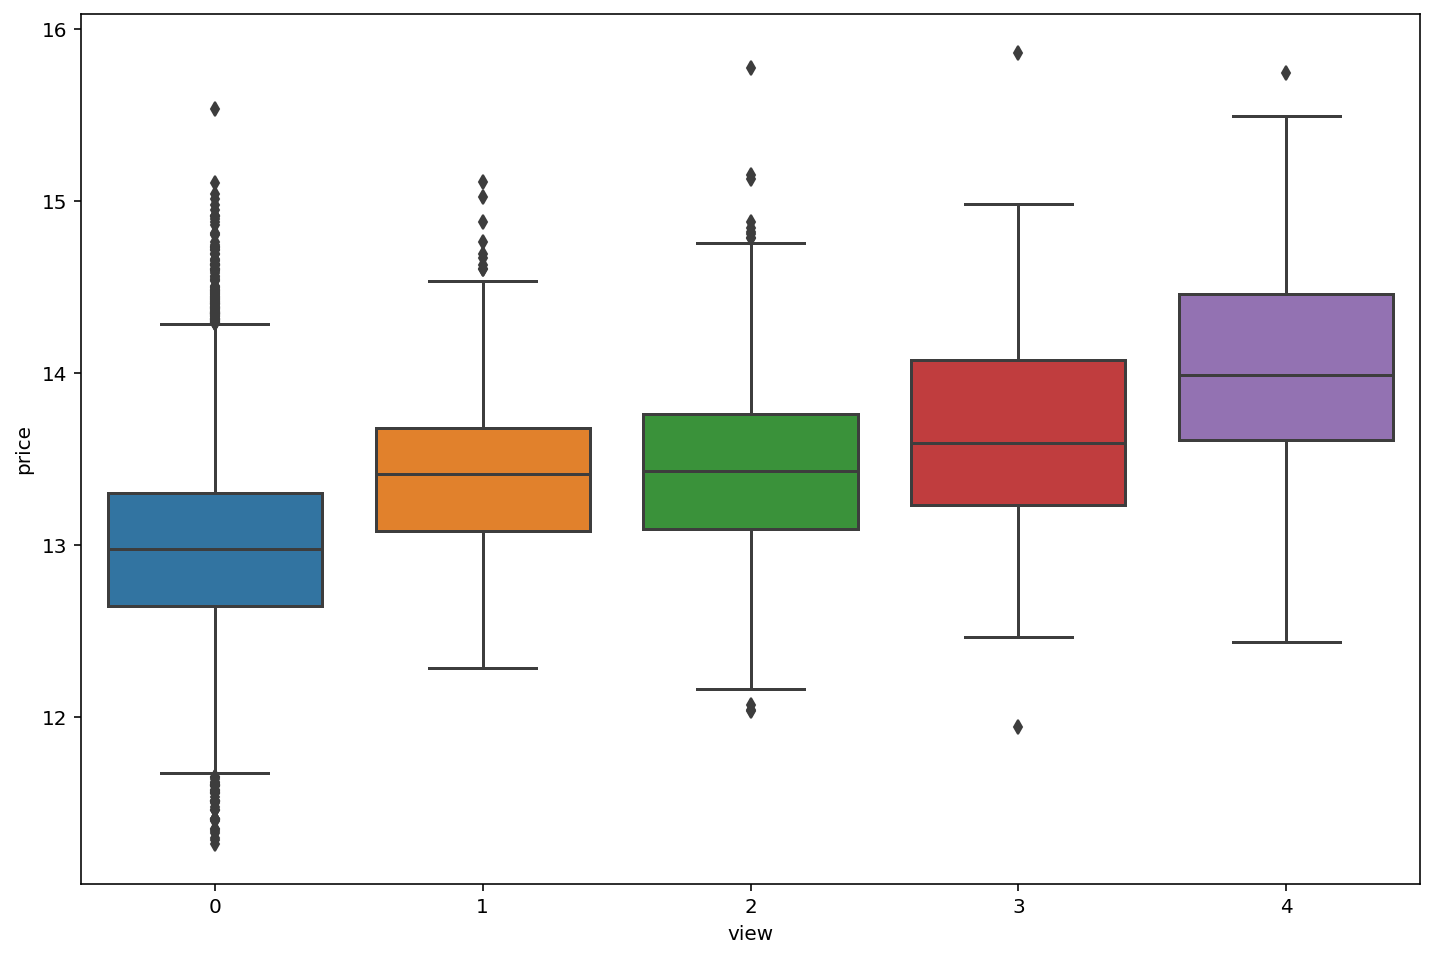

In [24]:
data = pd.concat([train['view'], train['price']], axis=1)
f, ac = plt.subplots(figsize=(12,8))
sns.boxplot(x='view', y='price', data=data)

<AxesSubplot:title={'center':'Test set'}, xlabel='view', ylabel='count'>

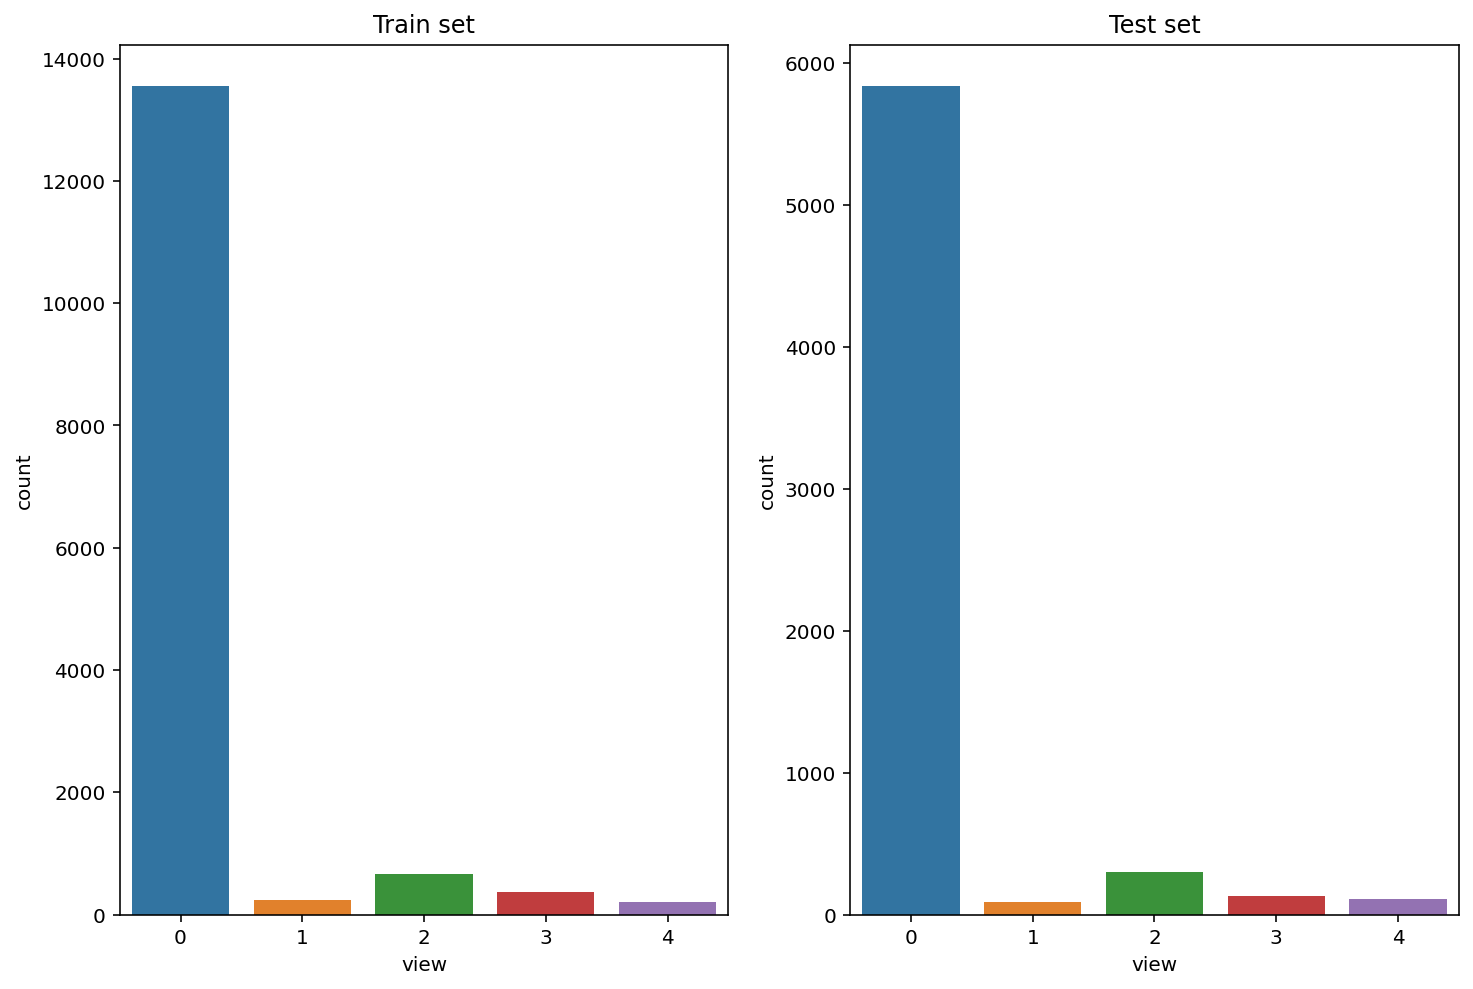

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
ax[0].set(title='Train set')
sns.countplot(x='view', data=train, ax=ax[0])

ax[1].set(title='Test set')
sns.countplot(x='view', data=test, ax=ax[1])

- 많이 보여준 방일수록 가격이 오르는것을 확인이 가능
- 분포가 대부분이 0쪽으로 치우쳐 있습니다.

<AxesSubplot:xlabel='waterfront', ylabel='price'>

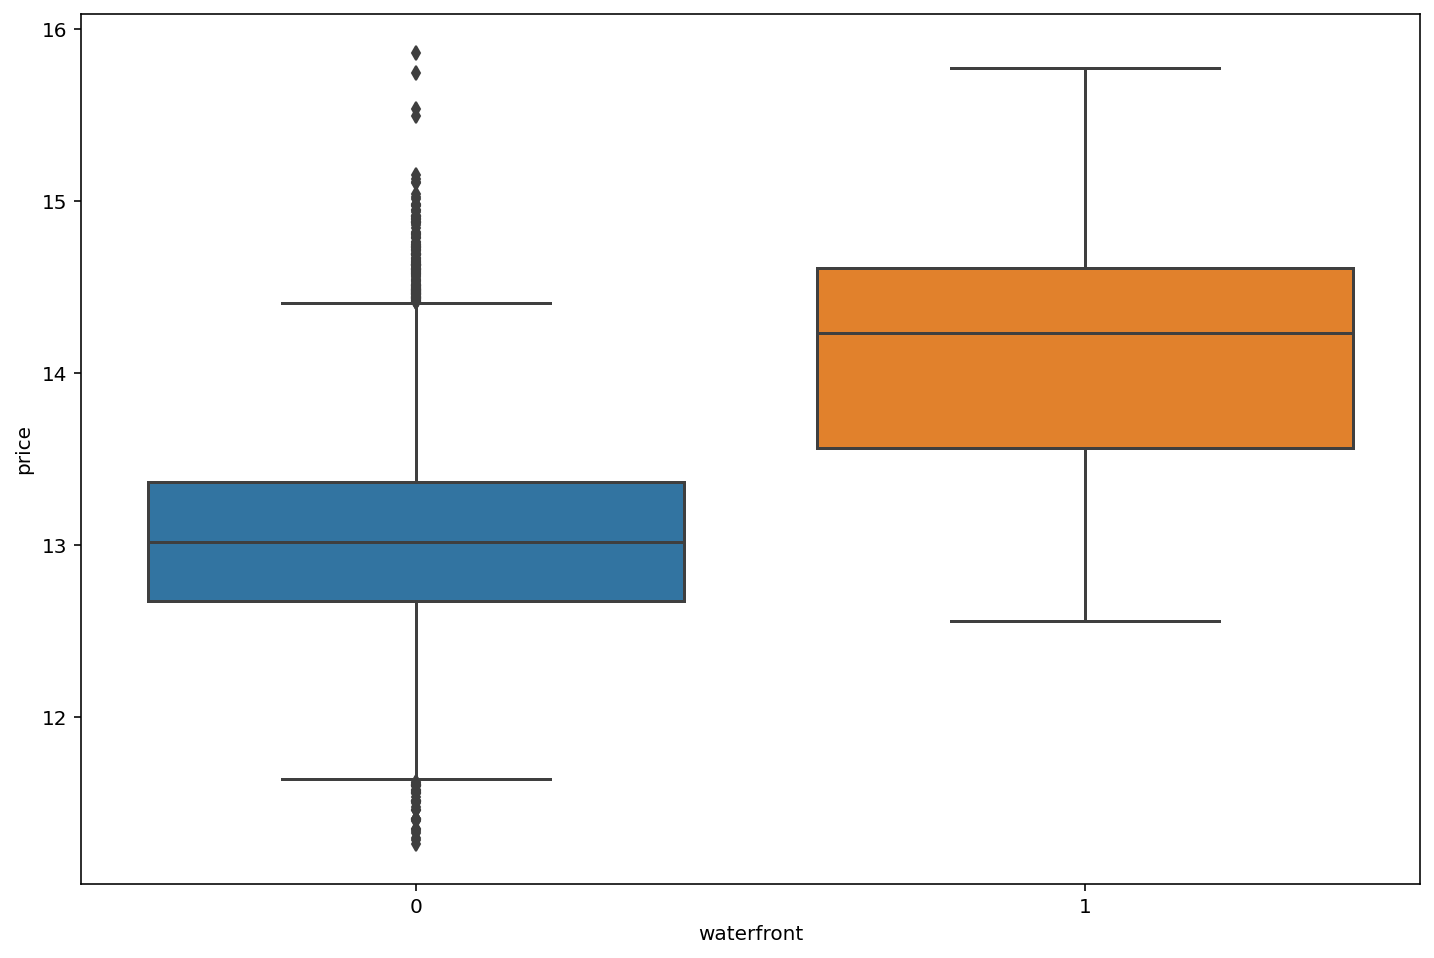

In [26]:
data = pd.concat([train['waterfront'], train['price']], axis=1)
f, ac = plt.subplots(figsize=(12,8))
sns.boxplot(x='waterfront', y='price', data=data)

<AxesSubplot:title={'center':'Test set'}, xlabel='waterfront', ylabel='count'>

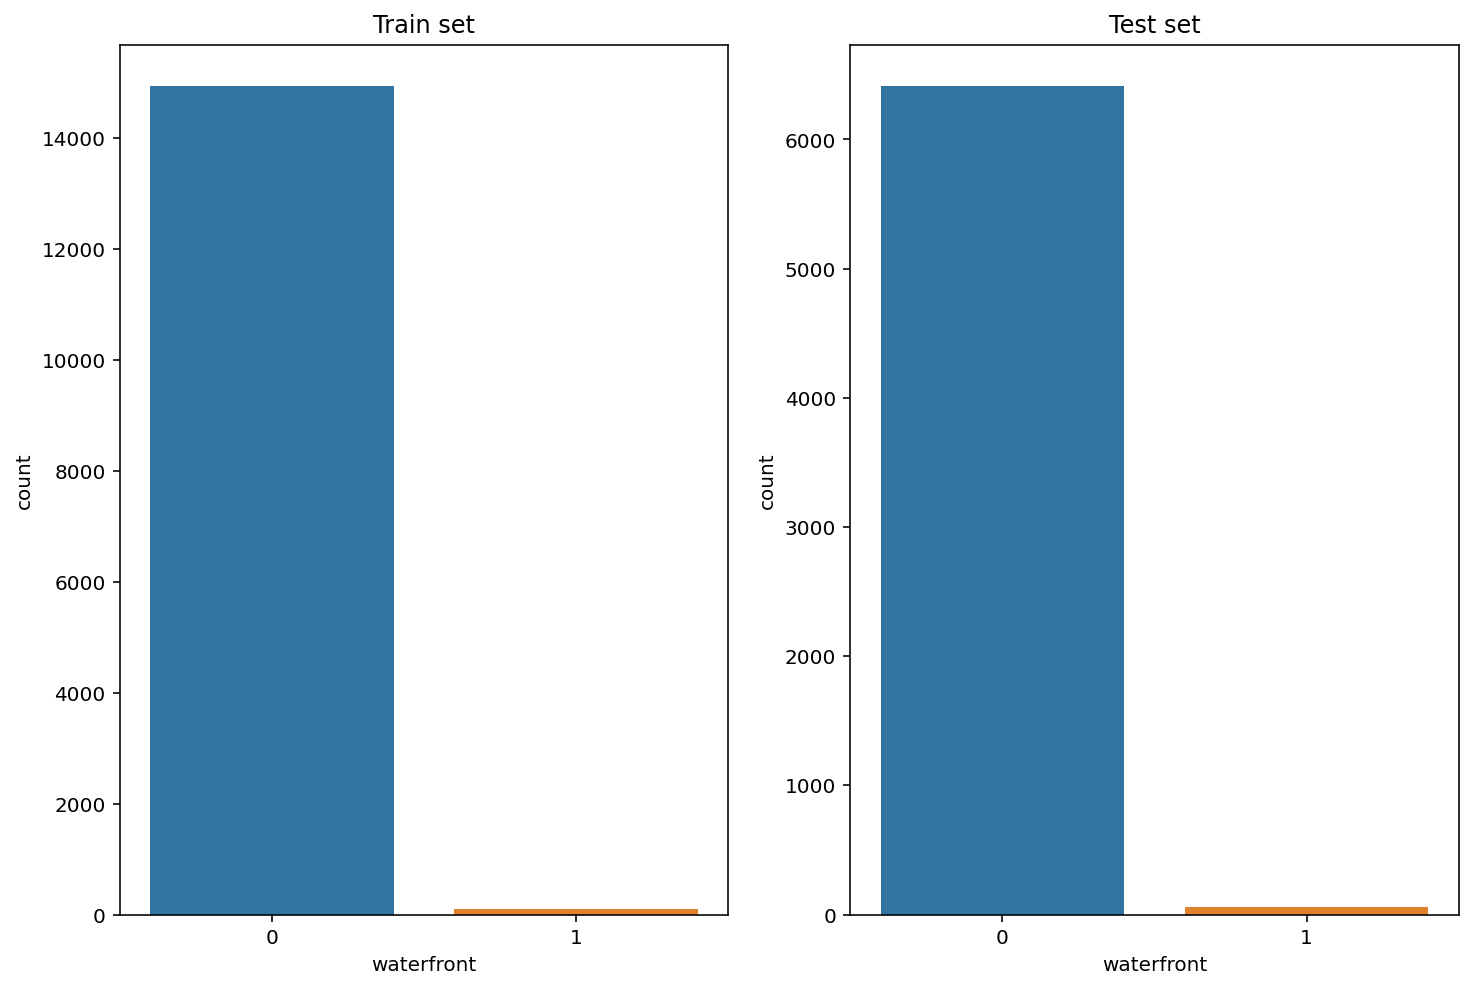

In [27]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
ax[0].set(title='Train set')
sns.countplot(x='waterfront', data=train, ax=ax[0])

ax[1].set(title='Test set')
sns.countplot(x='waterfront', data=test, ax=ax[1])

마찬가지로 분포가 0으로 쏠려있습니다.

1.4 결측치

<AxesSubplot:>

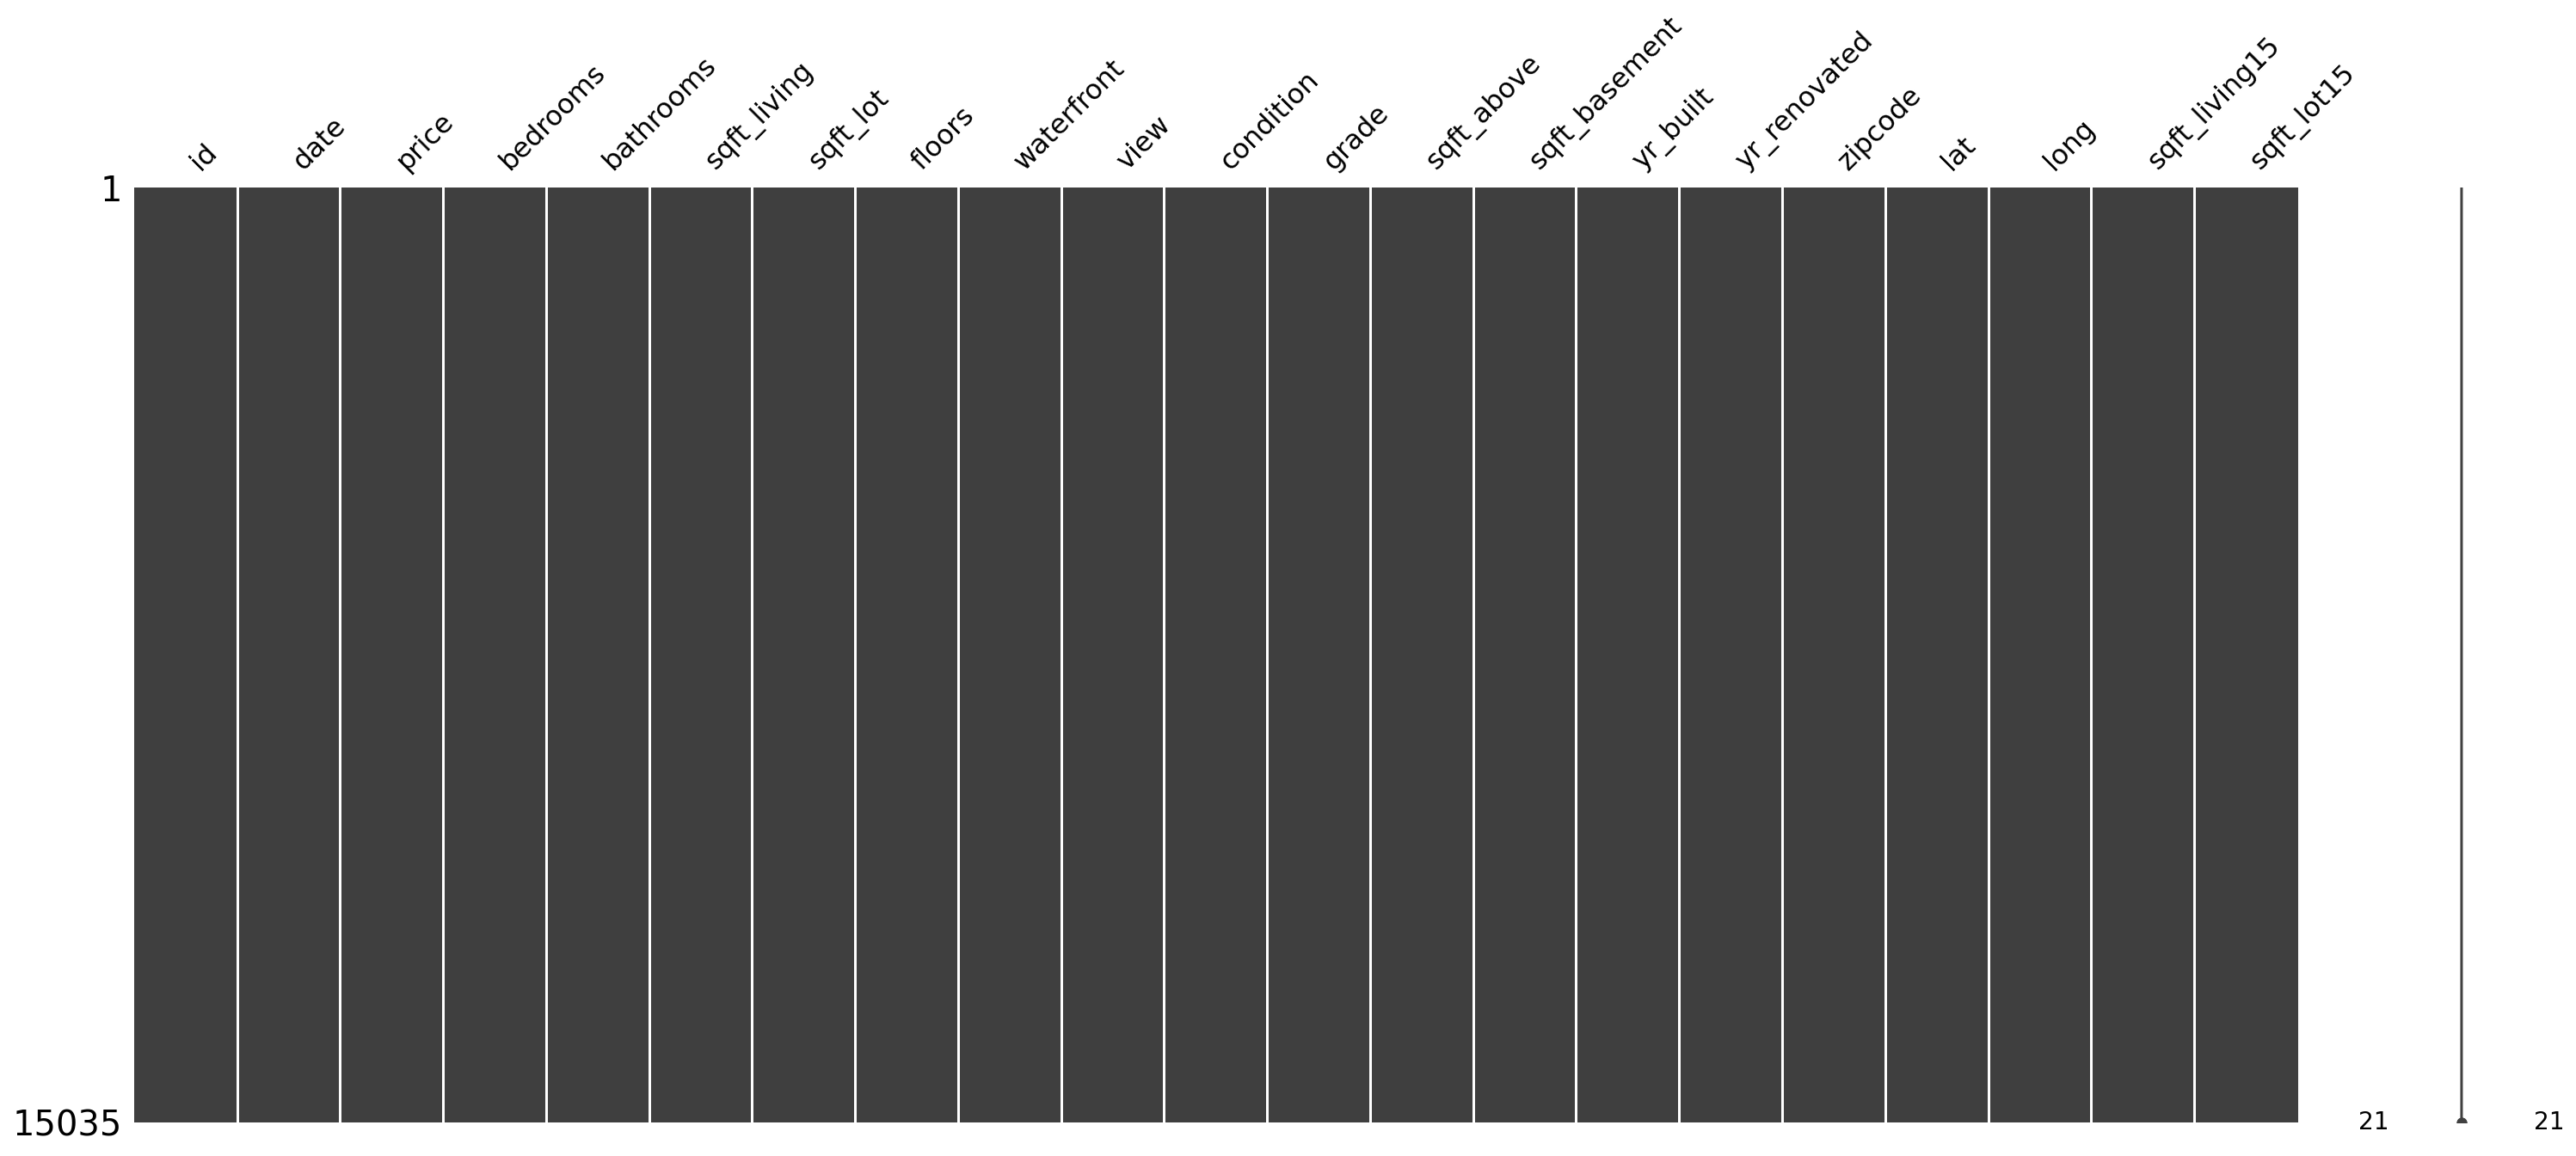

In [28]:
import missingno as msno
msno.matrix(train)

<AxesSubplot:>

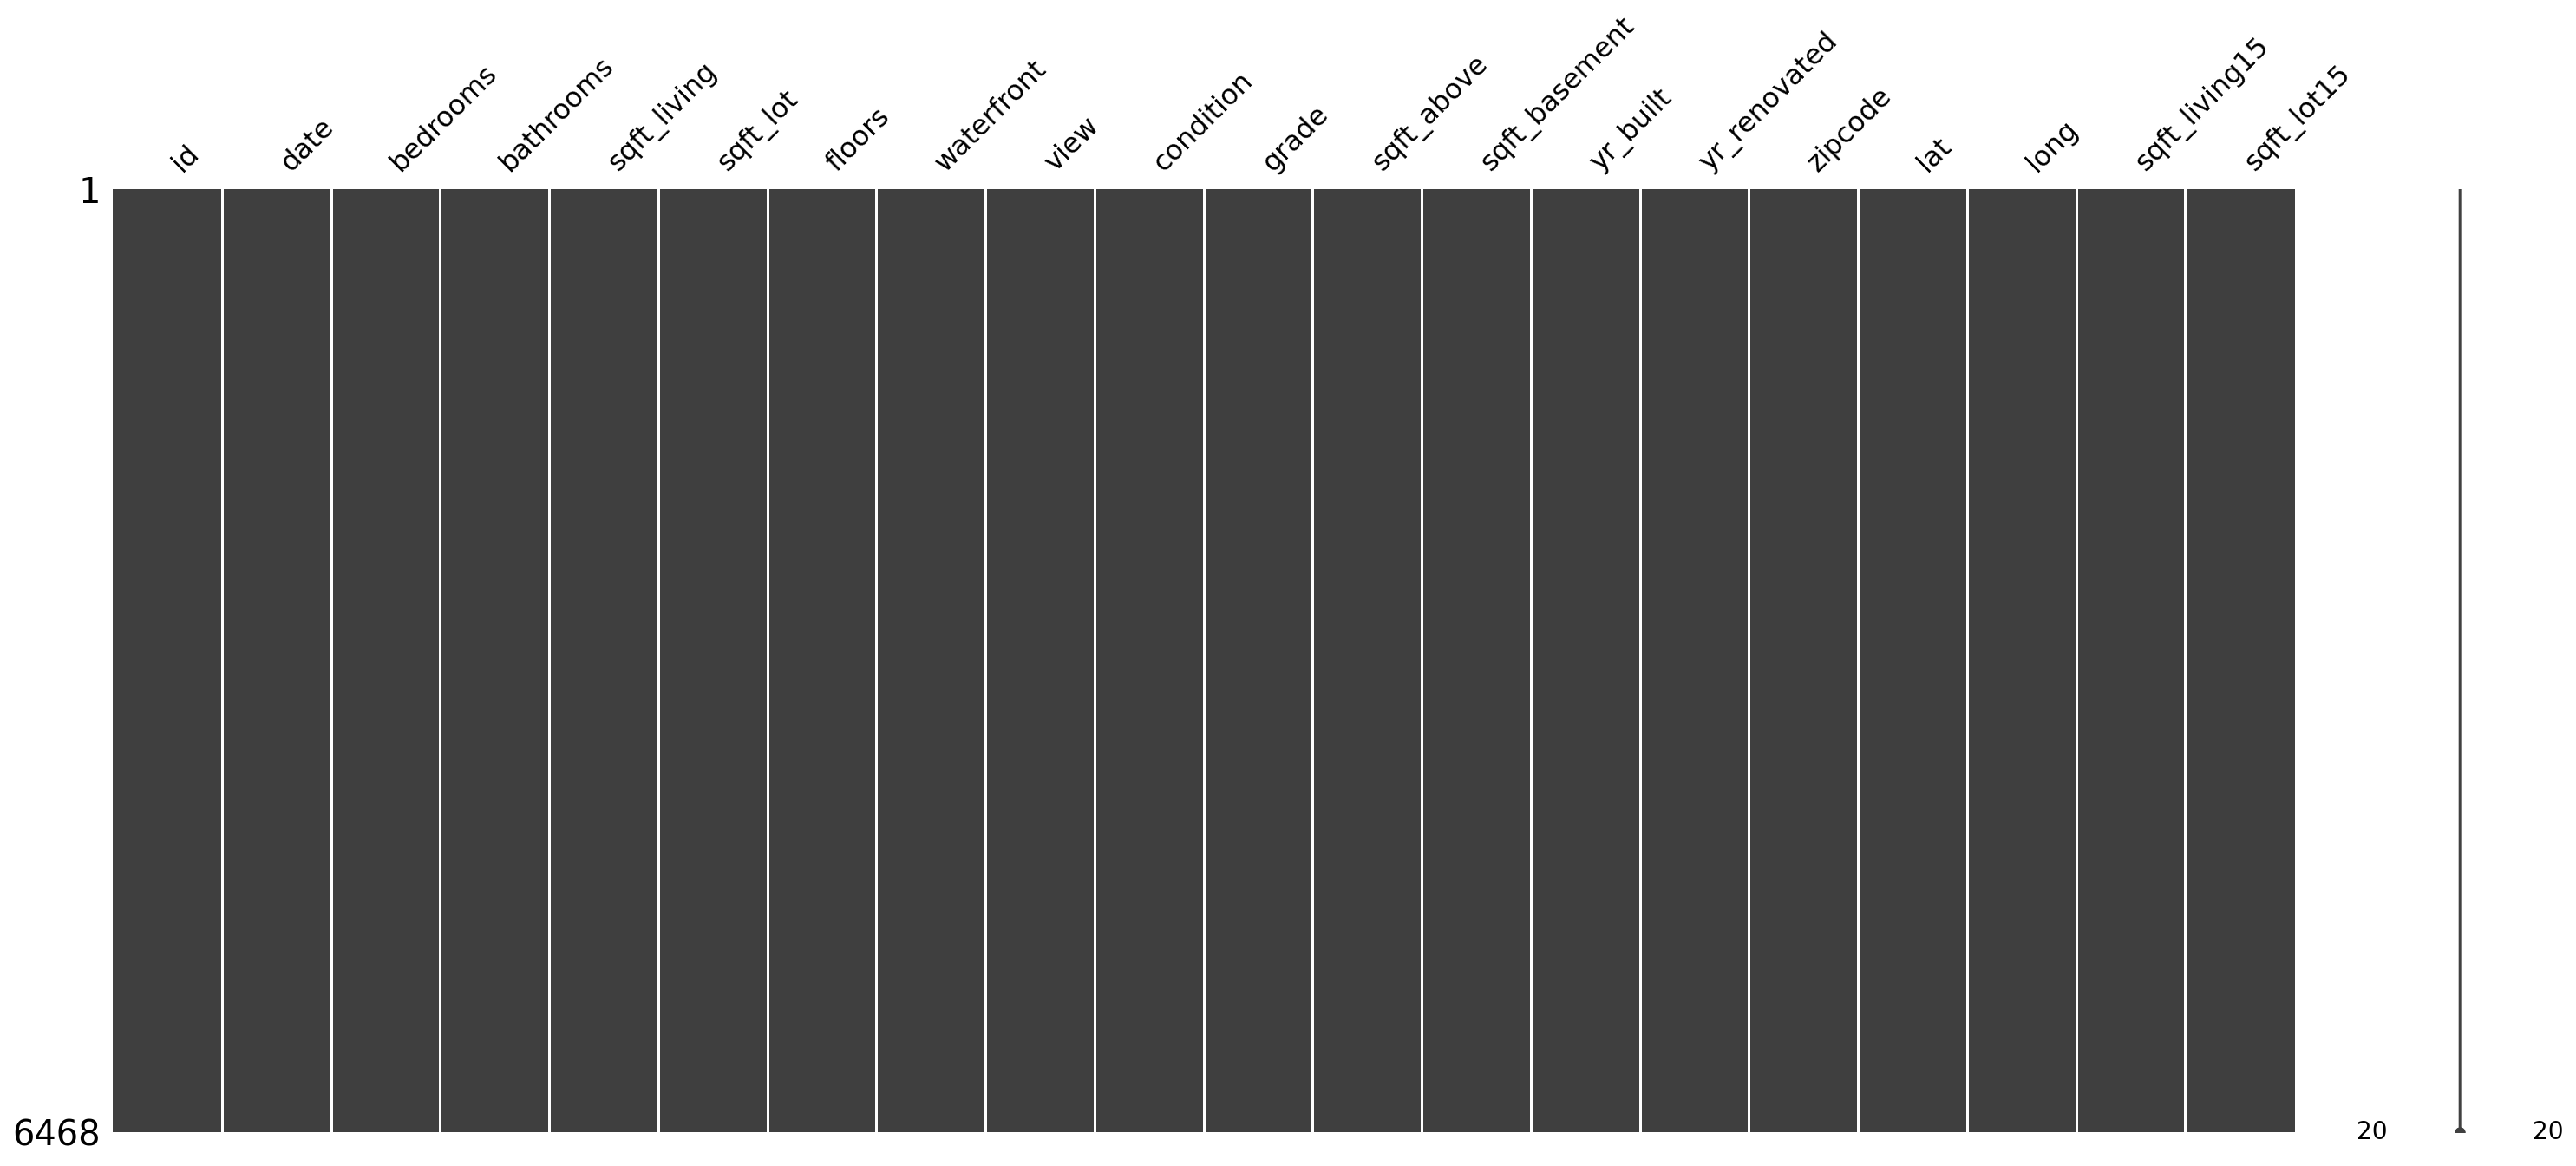

In [29]:
msno.matrix(test)

학습데이터, 테스트데이터 모두 결측치는 없는것으로 확인 됩니다

In [106]:
## 유니크 갯수 계산
!pip install plotly
import plotly as py
import plotly.graph_objs as go

train_unique=[]
columns = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

for i in columns:
    train_unique.append(len(train[i].unique()))
    
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont = dict(size=20),
        marker = dict(opacity=0.45)
    )
]

layout = go.Layout(
    title = 'Unique Value By Column',
    xaxis = dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Value Count', ticklen=5, gridwidth=2),
    showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='skin')


py, goName 에러, No module named plotly 가 나서 해당 라이브러리 임포트하여 오류를 해결했습니다

- import plotly as py
- import plotly.graph_objs as go
- !pip install plotly  처음했을때는 됐는데 왜 다시 돌리니까 안되는걸까. plotly 설치해서 해결했습니다

view의 유니크 개수가 5인걸로 보니 grade와 같이 순위형 변수로 생각되어지고, waterfront같은 경우는 2개로 있다, 없다를 뜻하는 것 같습니다.

2. 데이터 전처리

2.1 이상치 제거
위에서 중요한 변수들에 대해 다음의 변수들에 대해 이상치가 있는것을 확인할 수 있습니다.

sqft_living, grade, bathrooms

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

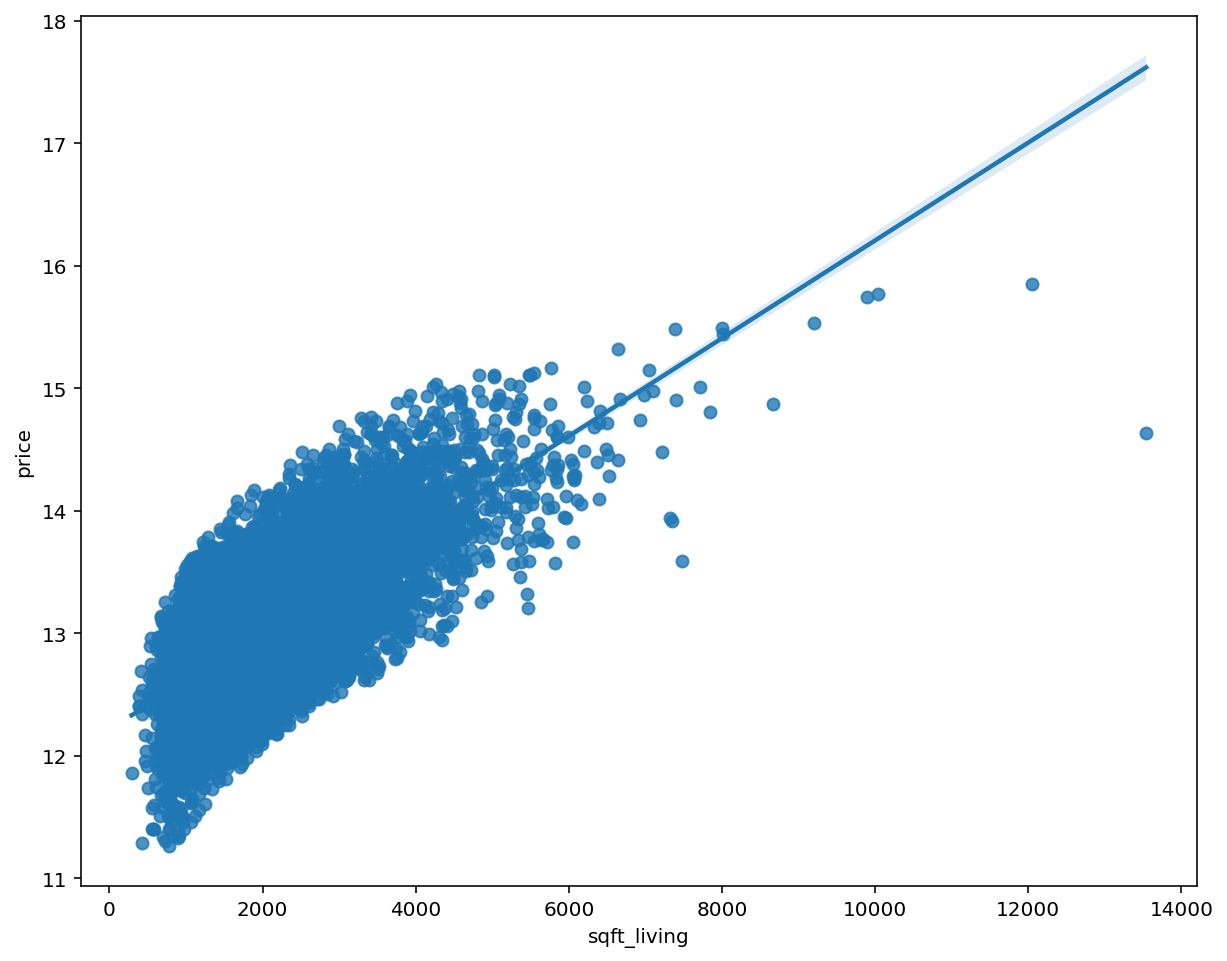

In [34]:
data = pd.concat([train['sqft_living'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.regplot(x='sqft_living', y='price', data=data)

In [35]:
train[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


위의 값을 봤을때, 다른값들에 비해 sqft_living 값만 비정상적으로 큰 것을 알 수 있습니다. 따라서 이 값은 이상치로 보고 제거하도록 하겠습니다.

In [36]:
train = train.loc[train['id'] != 8912]

<AxesSubplot:xlabel='grade', ylabel='price'>

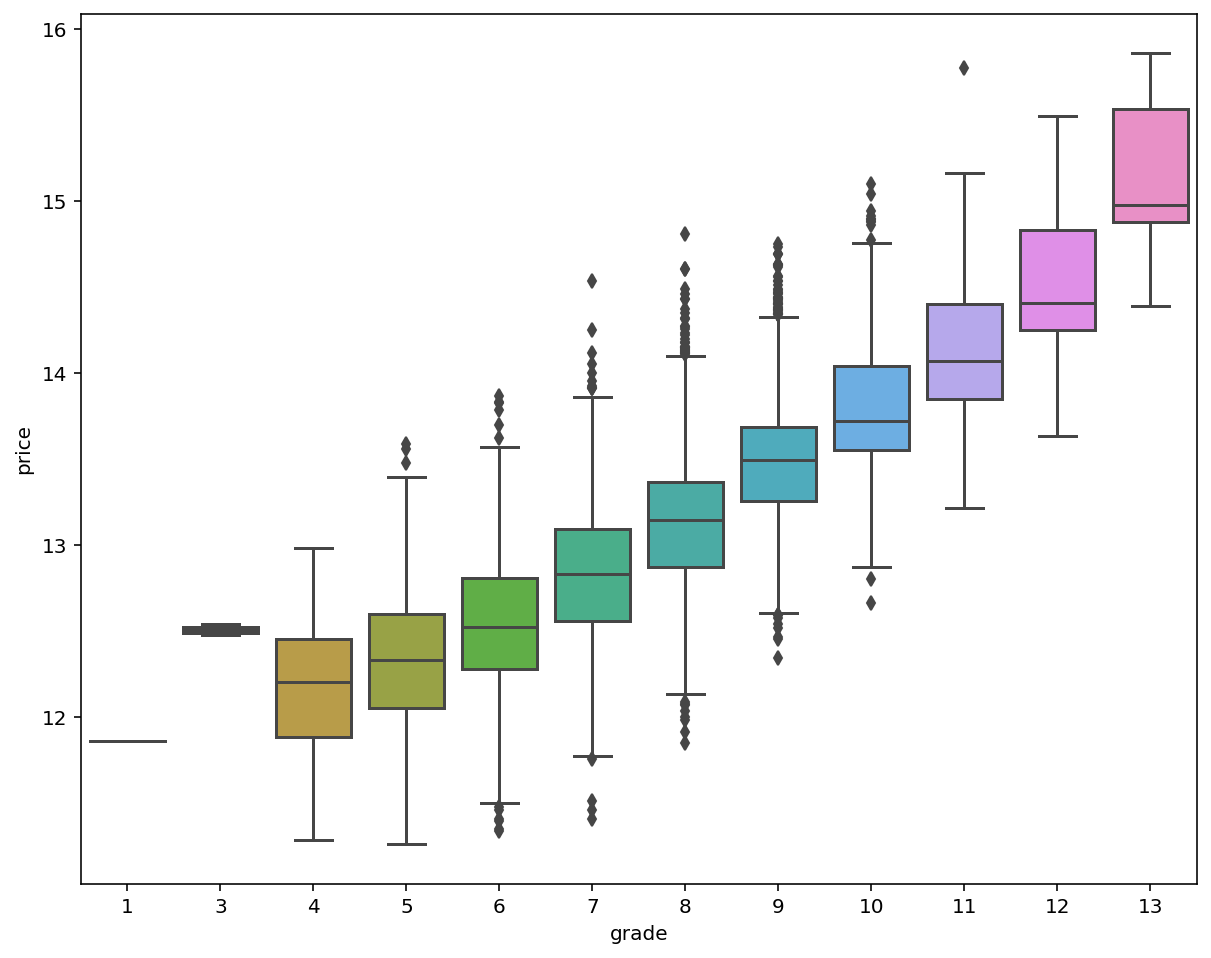

In [37]:
data = pd.concat([train['grade'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='grade', y='price', data=data)

In [38]:
train.loc[(train['price']>14.5) & (train['grade']==7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,...,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [39]:
train.loc[(train['price']>14.7) & (train['grade']==8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [40]:
train.loc[(train['price']>15.5) & (train['grade']==11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 3개의 값 모두 특별한 이유 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.

In [41]:
train = train.loc[train['id'] != 12346]
train = train.loc[train['id'] != 7173]
train = train.loc[train['id'] != 2775]

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

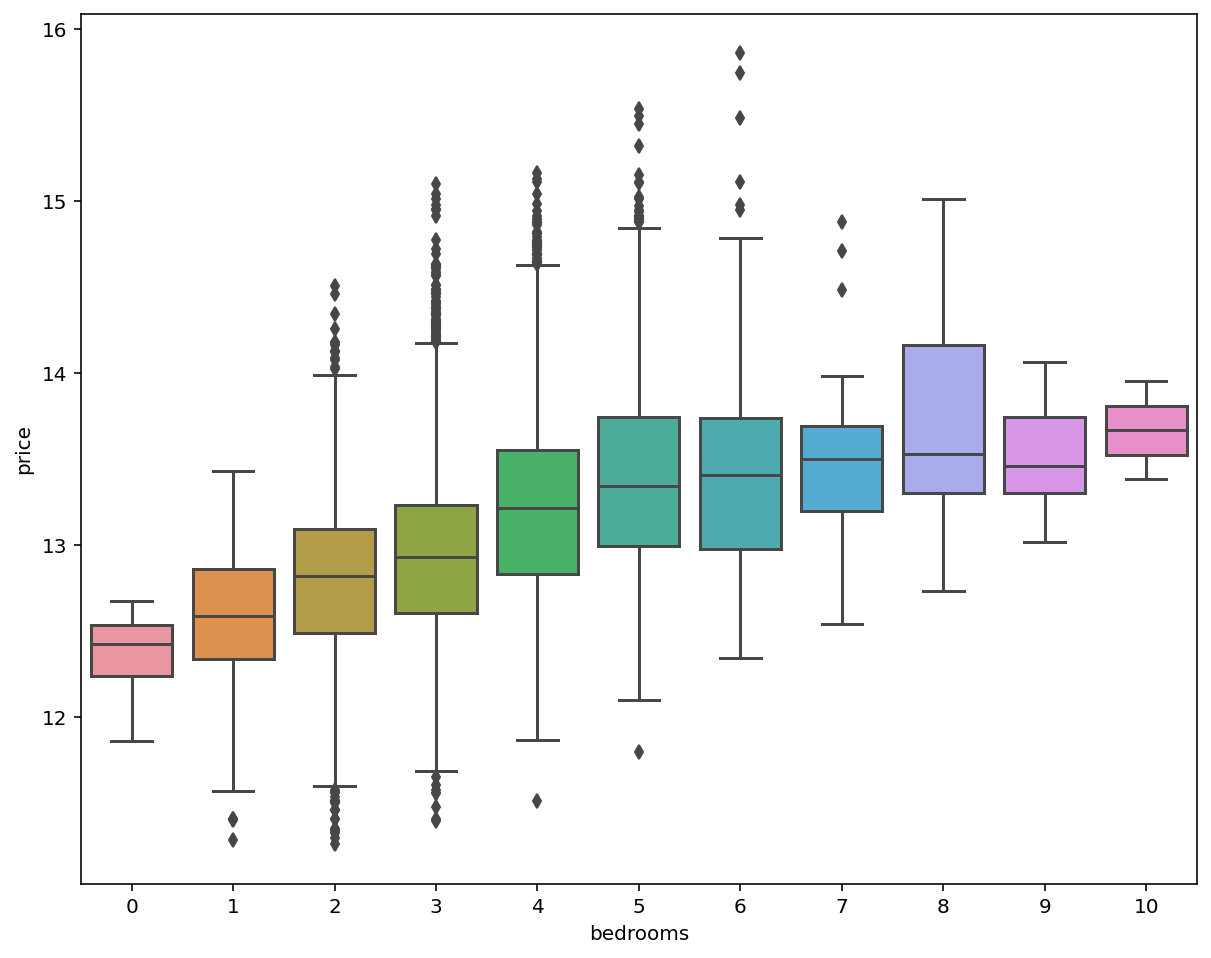

In [42]:
data = pd.concat([train['bedrooms'], train['price']], axis=1)
f, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='bedrooms', y='price', data=data)

침실의 수를 보면 9까지는 price가 증가하는 모습을 보이지만 10 이상부터는 그렇지 않습니다.

In [43]:
train.loc[train['bedrooms']>=10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9280,9280,20140814T000000,13.953533,10,5.25,4590,10920,1.0,0,2,...,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
10575,10575,20141029T000000,13.384729,10,2.00,3610,11914,2.0,0,0,...,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914


In [44]:
test.loc[test['bedrooms']>=10]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2584,17619,20140821T000000,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
4710,19745,20140625T000000,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
5775,20810,20141229T000000,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


2.2 정규화

baseline의 링크를 활용해 편향된 데이터들을 정규화 해주겠습니다.

In [45]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
skew_columns2 = ['sqft_living15', 'sqft_lot15'] # 1/3 제곱시켜 정규분포에 가깝게!

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)
    
for c in skew_columns2:
    train[c] = np.power(train[c].values, 1/3)
    test[c] = np.power(test[c].values, 1/3)

2.3 변수 수정

In [46]:
for df in [train, test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

3.변수 생성

In [47]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,11.024738,17.810775
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,13.959064,20.051534
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,12.164404,19.576948
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,13.080370,18.962994
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,11.816658,21.334771


In [48]:
for df in [train, test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    # 총 면적
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    # 면적 대비 거실 비율
#     df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15']
#     df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_total15'] 

    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x==0 else 1)
    df['date'] = df['date'].astype('int')

아래는 집값 같은 경우에는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야한다는 점입니다.

- 변수를 생성해 Polynomial한 특성을 추가해 준다.

In [49]:
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean', 'var'}).reset_index()
train = pd.merge(train, zipcode_price, how='left', on='zipcode')
test = pd.merge(test, zipcode_price, how='left', on='zipcode')
del train['per_price']

4. 모델링

In [50]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

In [51]:
y_reg = train['price']
del train['price']
del train['id']
test_id = test['id']
del test['id']

In [52]:
kfolds = KFold(n_splits=10, random_state=2019, shuffle=True)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(estimator=model, X=train, y=y_reg, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse

4.1 GBM

In [53]:
train_columns = [c for c in train.columns if c not in ['id']]

In [54]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

param = {
    'num_leaves' : 31,
    'min_data_in_leaf' : 10,
    'objective' : 'regression',
    'max_depth' : -1,
    'learning_rate' : 0.008,
    'min_child_samples' : 12,
    'boosting' : 'gbdt',
    'feature_fraction' : 0.3,
    'bagging_freq' : 1,
    'bagging_fraction' : 0.6,
    'bagging_seed' : 11,
    'metric' : 'rmse',
    'lambda_l2' : 8,
    'verbosity' : -1,
    'nthread' : -1,
    'random_state' : 2019
}

# prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof1 = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

# run model
for fold_, (trn_index, val_index) in enumerate(folds.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_index][train_columns], label=y_reg.iloc[trn_index])
    val_data = lgb.Dataset(train.iloc[val_index][train_columns], label=y_reg.iloc[val_index])
    
    num_round = 10000
    clf = lgb.train(params=param, train_set=trn_data, num_boost_round=num_round, valid_sets=[trn_data, val_data], verbose_eval=500, early_stopping_rounds=500)
    oof1[val_index] = clf.predict(train.iloc[val_index][train_columns], num_iterations=clf.best_iteration) # 나중에 스태킹을 위한 train 데이터도 된다.
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = train_columns
    fold_importance_df['importance'] = clf.feature_importance()
    
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # predictions
    predictions += clf.predict(test[train_columns], num_iterations=clf.best_iteration) / folds.n_splits # 나중에 스태킹을 위한 test 데이터도 된다.
    
cv = np.sqrt(mean_squared_error(oof1, y_reg))
print(cv)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=10
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 0.170166	valid_1's rmse: 0.186634
[1000]	training's rmse: 0.147575	valid_1's rmse: 0.170704
[1500]	training's rmse: 0.136464	valid_1's rmse: 0.165685
[2000]	training's rmse: 0.128391	valid_1's rmse: 0.163056
[2500]	training's rmse: 0.121888	valid_1's rmse: 0.161716
[3000]	training's rmse: 0.116335	valid_1's rmse: 0.160896
[3500]	training's rmse: 0.1114	valid_1's rmse: 0.160282
[4000]	training's rmse: 0.107004	valid_1's rmse: 0.159848
[4500]	training's rmse: 0.103017	valid_1's rmse: 0.159543
[5000]	training's rmse: 0.0992961	valid_1's rmse: 0.159315
[5500]	training's rmse: 0.0958098	valid_1's rmse: 0.159227
[6000]	training's rmse: 0.0925257	valid_1's rmse: 0.159121
[6500]	training's rmse: 0.0894619	valid_1's rmse: 0.159045
[7000]	training's rmse: 0.0865372	valid_1's rmse: 0.158914
Ea

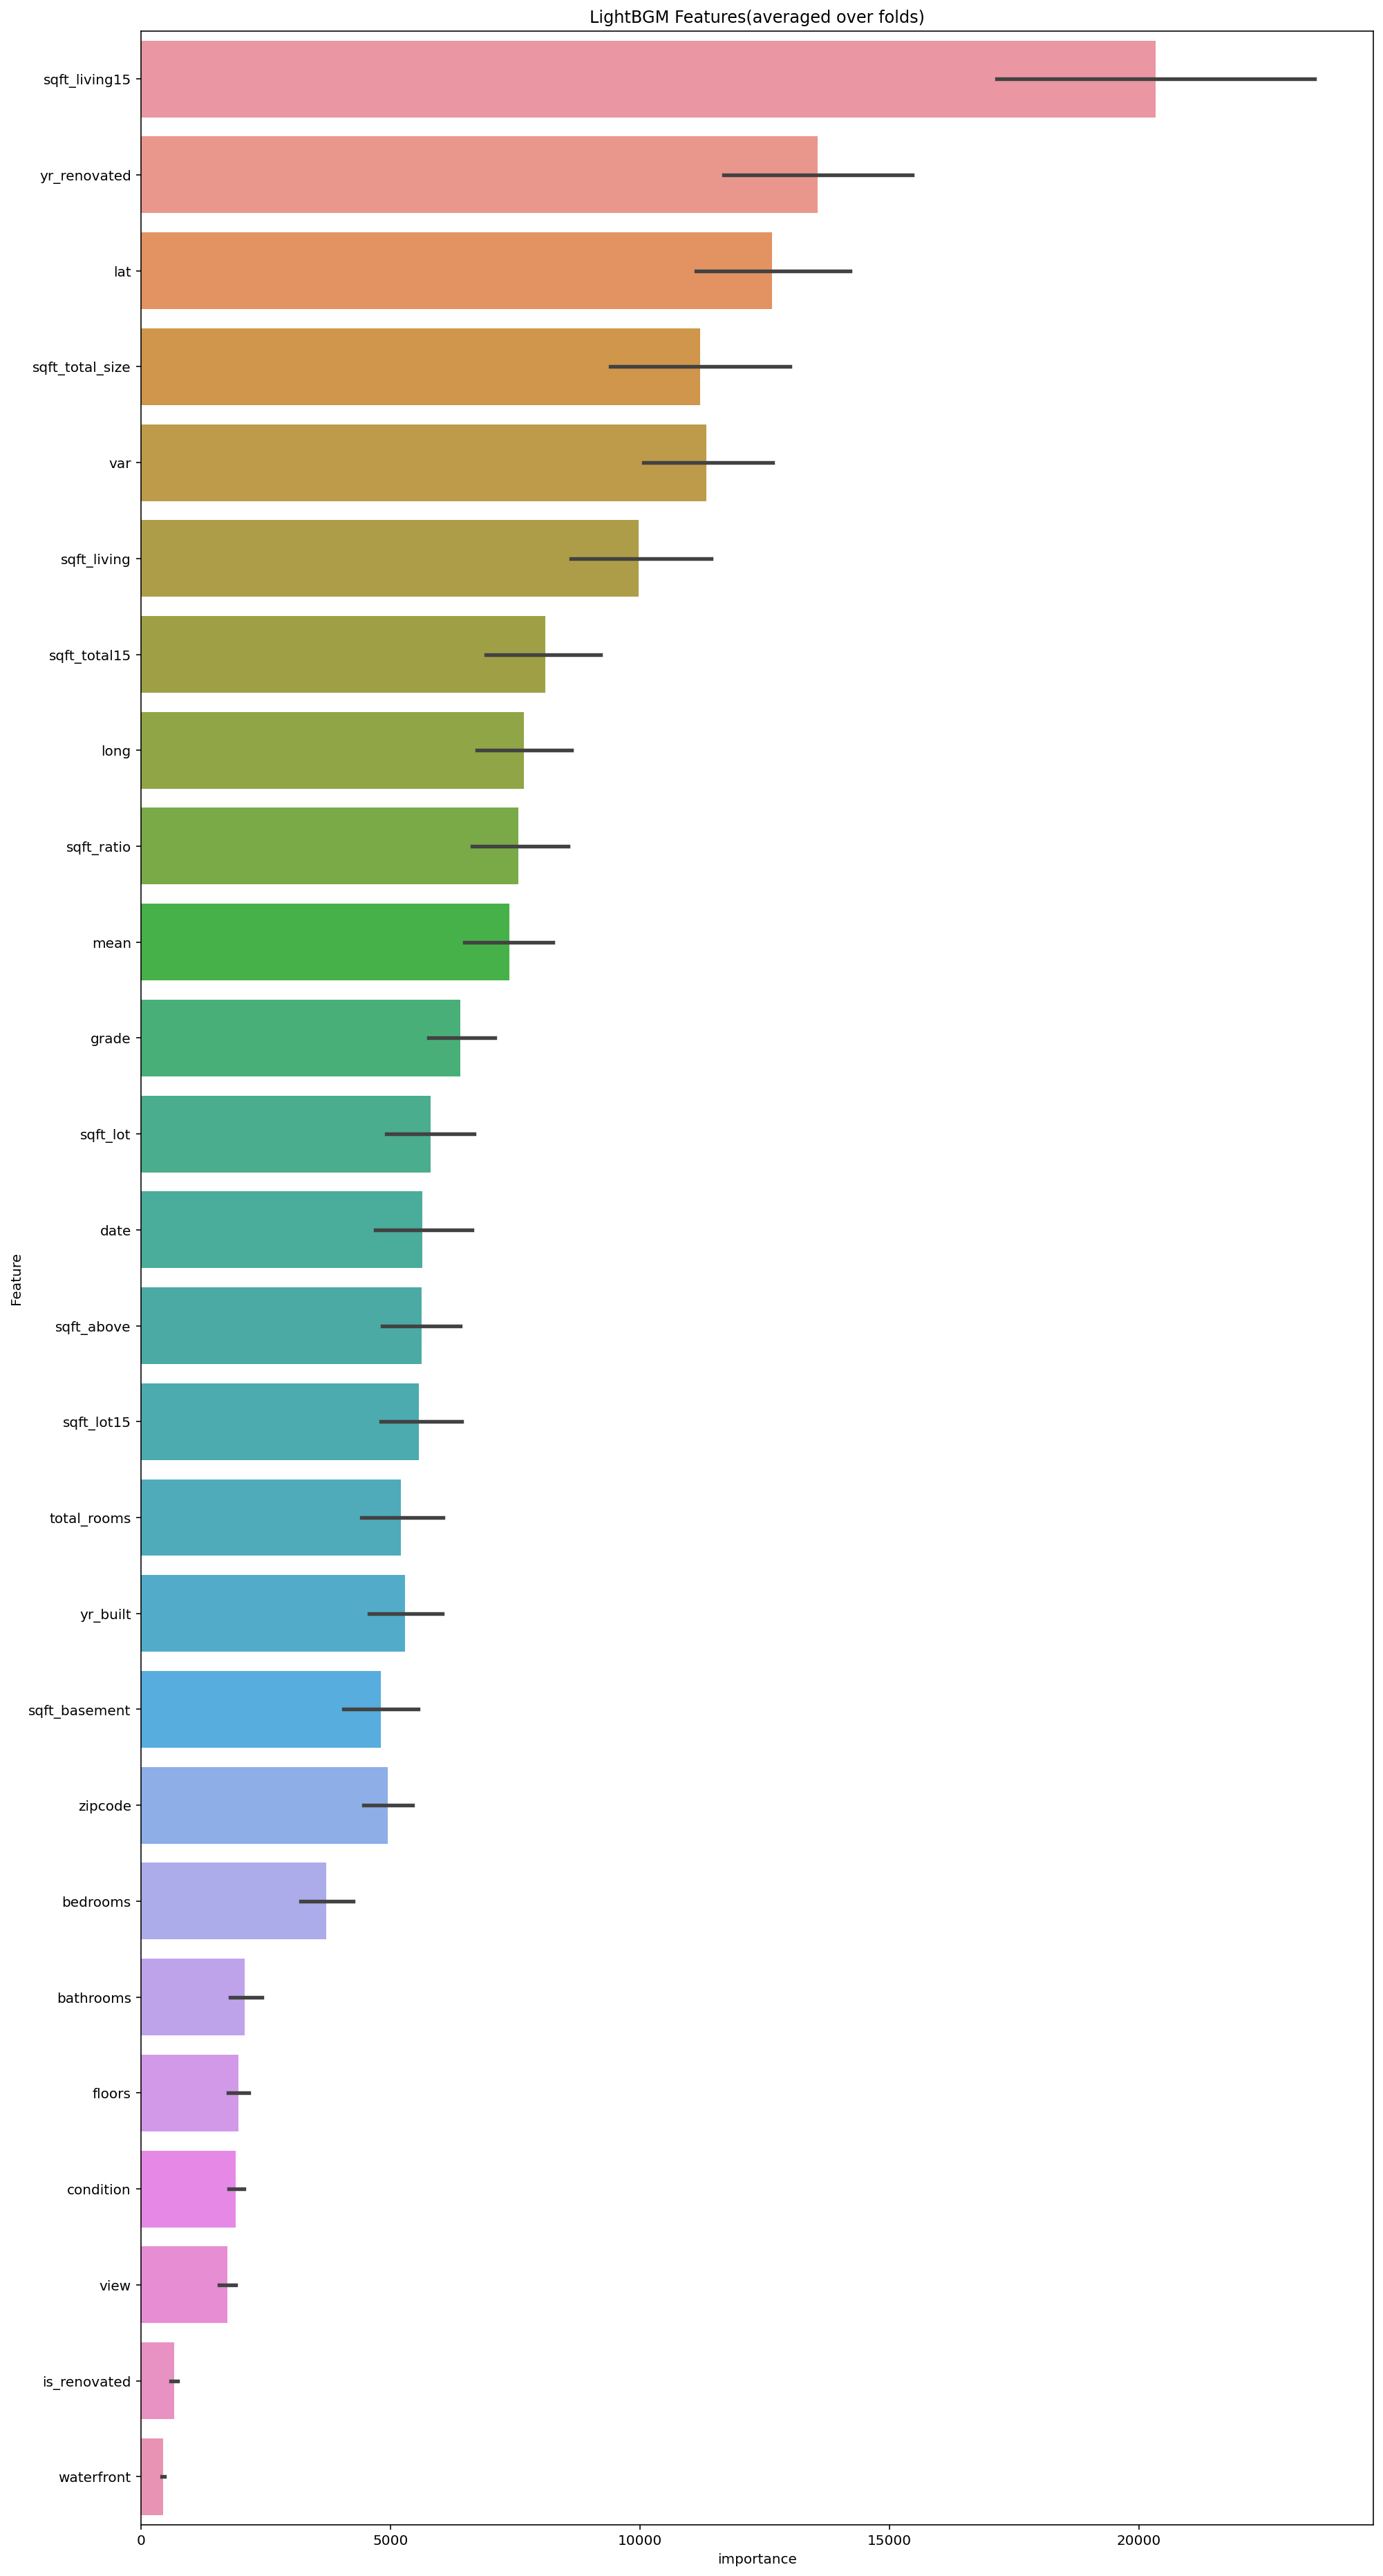

In [55]:
# plot the feature importance
cols = feature_importance_df[['Feature', 'importance']].groupby('Feature').mean().sort_values(by='importance',ascending=False)[:1000].index
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance',ascending=False))
plt.title('LightBGM Features(averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importaces.png')

l2 정규화의 수치를 높여 과적합을 막으면 public score가 더욱 좋아지고,
l2 정규화의 수치를 낮춰 과적합을 덜 막으면 private score가 좋아지는 경향이 있었습니다.

In [56]:
import xgboost as xgb

params = {
    'booster' : 'gbtree',
    'max_depth': 7,
    'eta' : 0.008,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'n_thread' : -1,
    'silent' : 1,
    'lambda' : 8,
    'sub_sample' : 0.5,
    'random_state' : 2019
}

# prepare fit model with cross-validation
oof2 = np.zeros(len(train))
predictions2 = np.zeros((len(test)))
feature_importance_df2 = pd.DataFrame()

num_rounds = 10000
for folds_, (trn_index, val_index) in enumerate(folds.split(train)):
    trn_dmtx = xgb.DMatrix(data=train.iloc[trn_index][train_columns].values, label=y_reg.iloc[trn_index].values)
    val_dmtx = xgb.DMatrix(data=train.iloc[val_index][train_columns].values, label=y_reg.iloc[val_index].values)
    
    wlist = [(trn_dmtx, 'train'),(val_dmtx, 'eval')]
    clf = xgb.train(params=params, dtrain=trn_dmtx, num_boost_round=num_rounds, evals=wlist, verbose_eval=100, early_stopping_rounds=100)
    oof2[val_index] = clf.predict(data=val_dmtx) # 스태킹 모델링을 위해 남겨놓는다(스태킹 모델의 훈련 데이터)
    
    # 스테킹 모델의 테스트 데이터가 된다.
    predictions2 += clf.predict(data=xgb.DMatrix(data=test[train_columns].values)) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof2, y_reg))
print(cv)

[02:08:29] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[02:08:29] WARNING: ../src/learner.cc:573: 
Parameters: { "n_thread", "silent", "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:12.45878	eval-rmse:12.45707
[100]	train-rmse:5.59746	eval-rmse:5.59647
[200]	train-rmse:2.52641	eval-rmse:2.52549
[300]	train-rmse:1.15619	eval-rmse:1.15566
[400]	train-rmse:0.55168	eval-rmse:0.55346
[500]	train-rmse:0.29529	eval-rmse:0.30208
[600]	train-rmse:0.19746	eval-rmse:0.21137
[700]	train-rmse:0.16418	eval-rmse:0.18338
[800]	train-rmse:0.15223	eval-rmse:0.17461
[900]	train-rmse:0.14590	eval-rmse:0.17065
[1000]	train-rmse:0.14150	eval-rmse:0.16840
[1100]	train-rmse:0.13800	eval-rmse:0.16693
[1200]	tr

그와 다르게 XGBoost는 과적합을 어느정도 막는것이 private score와 public score 둘 다 좋은 점수를 가져왔습니다.

4.2 랜덤포레스트(RandomForest)

In [57]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=300, random_state=2019, max_depth=15, n_jobs=-1).fit(train, y_reg)

In [58]:
print('RandomForest rmse:', cv_rmse(rf_reg).mean())

RandomForest rmse: 0.17558087113414714


<AxesSubplot:>

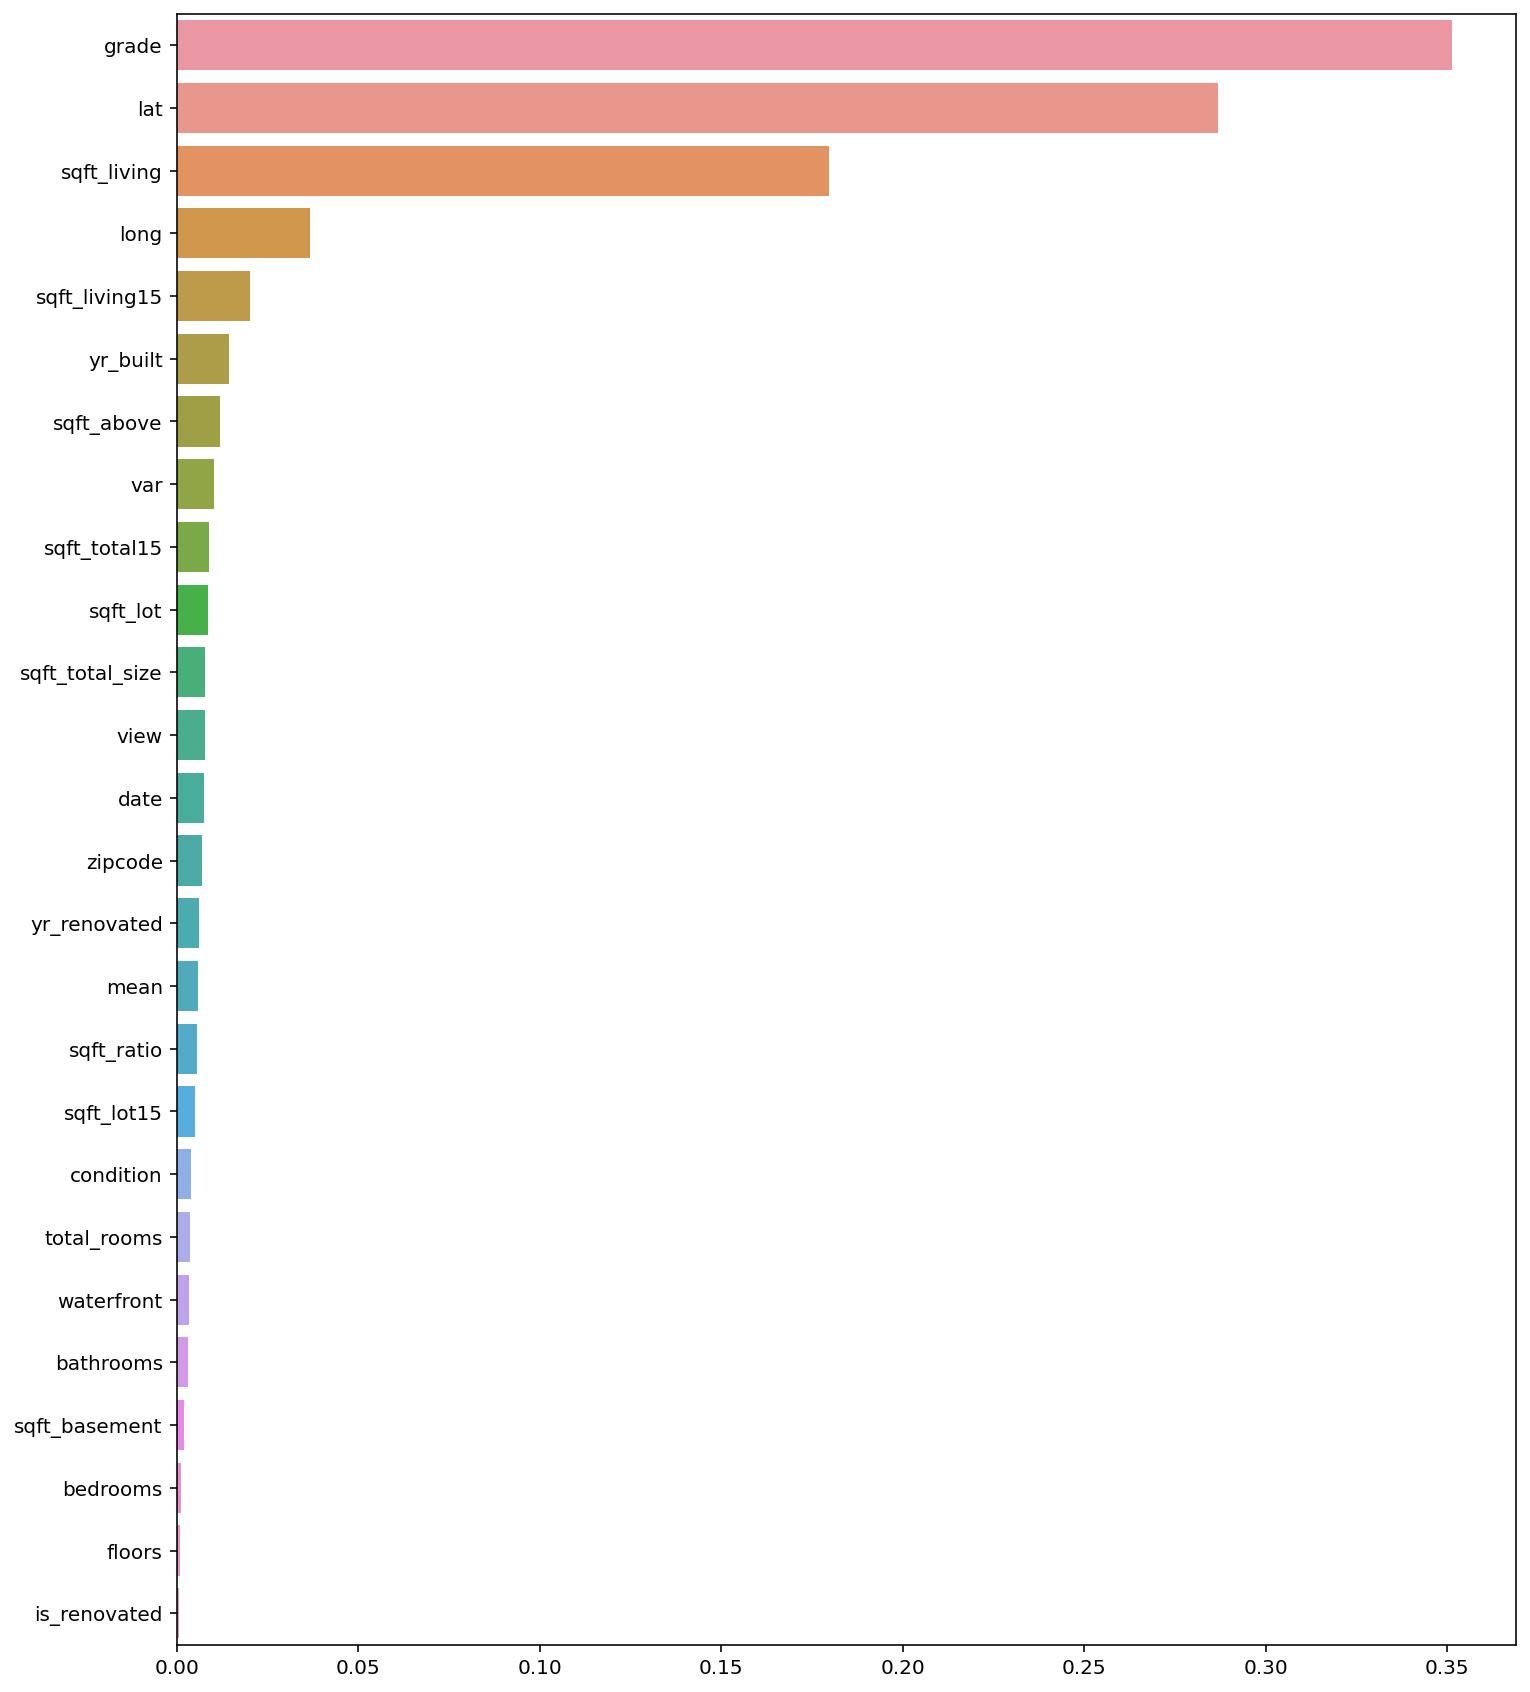

In [59]:
# plot the feature importance
feature_importance_df_rf = pd.Series(data=rf_reg.feature_importances_, index=train.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,15), nrows=1, ncols=1)
sns.barplot(x=feature_importance_df_rf, y=feature_importance_df_rf.index, ax=ax)

4.3 서포트벡터머신

In [60]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

svr_reg = make_pipeline(StandardScaler(), SVR(C=3.5)).fit(train, y_reg)

In [61]:
print('Support Vector Regressor rmse :', cv_rmse(svr_reg).mean())

Support Vector Regressor rmse : 0.18550762499568527


4.4 ExtraTreeRegressor

In [62]:
from sklearn.tree import ExtraTreeRegressor

extra_tree_reg = ExtraTreeRegressor(criterion='mse', max_depth=15, min_samples_leaf=10, min_samples_split=10, max_features='auto',random_state=2019).fit(train, y_reg)

In [63]:
print('ExtraTreeRegressor rmse :', cv_rmse(extra_tree_reg).mean())

ExtraTreeRegressor rmse : 0.2232807237021565


4.5 다층 퍼셉트론(Keras) 

In [64]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import keras.backend as K

In [65]:
# 먼저 모델링 전 데이터들을 퍼셉트론이 가장 잘 학습할 수 있도록 정규화 해주도록 하자.
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(train)
y_scaler = StandardScaler().fit(y_reg.values.reshape(-1,1))

x_train = x_scaler.transform(train)
x_test = x_scaler.transform(test)
y_train = y_scaler.transform(y_reg.values.reshape(-1,1))

In [66]:
print(x_train.shape[1])

26


In [67]:
np.random.seed(2019) # for reproduction

In [68]:
# root mean squared error를 평가 메트릭으로 사용하기위해 함수를 정의
def root_mean_squared_error(y_pred, y_true):
    squared_err = K.square(K.sum(y_true - y_pred, axis=0))
    mse = K.mean(squared_err)
    return K.sqrt(mse)

In [69]:
# 모델링
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(12, activation='relu', input_dim=x_train.shape[1], kernel_initializer='he_uniform'))
    model.add(layers.Dense(6, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1))
    
    optimizer = optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=[root_mean_squared_error])
    
    return model

In [70]:
# 하이퍼 파라미터 정의
epoch = 200
patient = 20
k = 5
folds = KFold(n_splits=k, shuffle=True, random_state=2019)

In [71]:
import os
model_path = './model'

if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_path1 = model_path + 'adam_model1.h5'

훈련중 모델 결과를 저장할 디렉터리, 파일명

In [72]:
call_backs = [
    EarlyStopping(monitor='mse', patience=patient, mode='min', verbose=1),
    ModelCheckpoint(filepath=model_path1, monitor='mse', verbose=1, save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patient/3, min_lr=0.000001, verbose=1, mode='min')
]

에폭은 200, 각 훈련마다 patient는 20, 5폴드 1개 모델로 하고 KFold를 사용해 Fold는 섞었다.

In [89]:
# 스태킹 모델링을 위해
oof_percep = np.zeros(len(x_train))
prediction_percep = np.zeros(len(x_test))
from tensorflow.keras import optimizers # module 'keras.optimizers' has no attribute 'Adam'에러가 떠서 해당 라이브러리 임포트

# 학습
for folds_, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print('처리중인 폴드 #', folds_)
    # 학습 데이터
    partial_train_data = x_train[trn_idx]
    partial_train_targets = y_train[trn_idx]
    
    # 검증 데이터
    val_data = x_train[val_idx]
    val_targets = y_train[val_idx]
    
    model = build_model()
    history = model.fit(partial_train_data,
                       partial_train_targets,
                       validation_data=(val_data, val_targets),
                        epochs=epoch,
                        batch_size=16,
                        callbacks=call_backs
                       )
    # 가중치 저장
    if not os.path.exists('./weight_data'):
        os.mkdir('./weight_data')
#     model.save_weights('./weight_data/train_fold{}'.format(folds_))
        
    
    oof_percep[val_idx] = model.predict(val_data).squeeze()
    prediction_percep += model.predict(x_test).squeeze() / folds.n_splits

처리중인 폴드 # 0
Epoch 1/200
752/752 [==============================] - 4s 3ms/step - loss: 0.5293 - root_mean_squared_error: 3.6345 - val_loss: 0.3372 - val_root_mean_squared_error: 2.8522
Epoch 2/200
752/752 [==============================] - 2s 3ms/step - loss: 0.2758 - root_mean_squared_error: 1.8257 - val_loss: 0.2481 - val_root_mean_squared_error: 2.0613
Epoch 3/200
752/752 [==============================] - 2s 2ms/step - loss: 0.2206 - root_mean_squared_error: 1.5840 - val_loss: 0.2134 - val_root_mean_squared_error: 1.5456
Epoch 4/200
752/752 [==============================] - 2s 2ms/step - loss: 0.1944 - root_mean_squared_error: 1.4834 - val_loss: 0.1895 - val_root_mean_squared_error: 1.4628
Epoch 5/200
752/752 [==============================] - 2s 2ms/step - loss: 0.1788 - root_mean_squared_error: 1.3837 - val_loss: 0.1772 - val_root_mean_squared_error: 1.4024
Epoch 6/200
752/752 [==============================] - 2s 3ms/step - loss: 0.1696 - root_mean_squared_error: 1.3465 - val_l

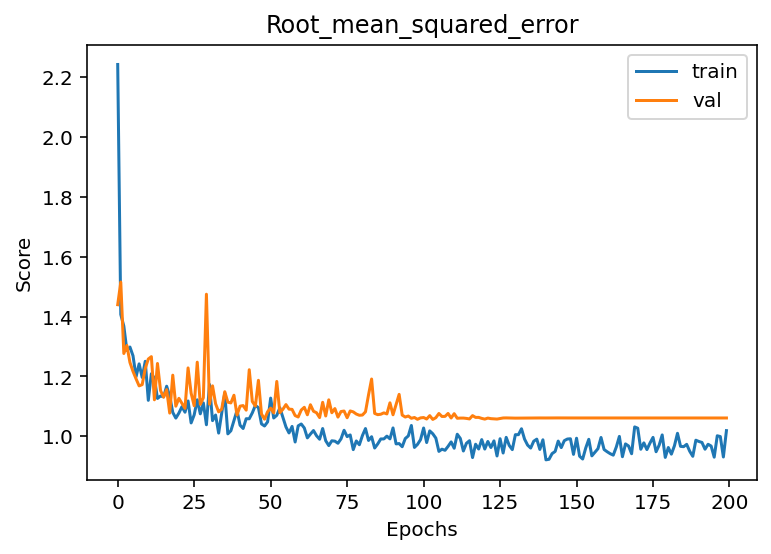

In [90]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root_mean_squared_error')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(['train', 'val'], loc='best')

In [91]:
# 예측결과를 저장해놓는다.
percep_model_preds = model.predict(x_test)

12->6->3 으로 총 3개의 은닉층을 구성하였습니다.
12->6 으로 2개의 은닉층을 구성하면 public score는 좋아졌는데 private score의 점수가 나빠졌고, 위와같이 3개의 층을 구성하면 public score는 나빠지고 private score는 좋아지는 결과가 나왔습니다.
그 이유는 더욱 연구해보아야 할 듯 합니다.
가중치 초기화는 활성화 함수를 relu 함수를 썼기 때문에 he 초기화를 했습니다.
l2 패널티는 0.001로 주었습니다.

4.6 스태킹(Stacking)

In [92]:
# 두 종류의 모델이 필요하다.
# 하나는 지금까지 학습시킨 개별적인 기본모델들이고,
# 다른 하나는 개별 기반 모델의 예측 데이터를 학습데이터로 만들어서 학습하는 최종 메타 모델이다.

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n):
    # KFold는 위에서 만들어진것을 쓴다.
    # 추후에 메타 모델이 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((train.shape[0], 1))
    test_pred = np.zeros((test.shape[0], folds.n_splits))
    print(model.__class__.__name__, ' model 시작')
    
    for folds_, (trn_index, val_index) in enumerate(folds.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t폴드 세트: ', folds_, ' 시작')
        trn_data = X_train_n.iloc[trn_index]
        val_data = X_train_n.iloc[val_index]
        y_trn = y_train_n.iloc[trn_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(trn_data, y_trn)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[val_index,:] = model.predict(val_data).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folds_] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1)
    
    # train_fold_predsms 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [94]:
# xgboost와 lightgbm은 각각 oof1,oof2 | predictions, predictions2 로 만들어져 있으니 RandomForest와 SVR, ExtraTree 모델들만 구해본다.
rf_train, rf_test = get_stacking_base_datasets(rf_reg, train, y_reg, test)
svr_train, svr_test = get_stacking_base_datasets(svr_reg, train, y_reg, test)
extra_train, extra_test = get_stacking_base_datasets(extra_tree_reg, train, y_reg, test)

# xgboost와 lightgbm의 앙상블도 준비해보자.
# 비율은 0.4*xgb + 0.6*lgb
oof3 = 0.6 * oof1 + 0.4 * oof2
predictions3 = 0.6 * predictions + 0.4 * predictions2

RandomForestRegressor  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
Pipeline  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
ExtraTreeRegressor  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작


In [103]:
from sklearn.linear_model import Ridge

# 개별 모델이 반환한 테스트용 데이터 세트를 스태킹 형태로 결합
## 스택모델1 : 랜덤포레스트, XGB, LGB, SVR, 엑스트라 랜더마이즈 트리
# Stack_final_X_train = np.concatenate([rf_train, oof1.reshape(-1,1), oof2.reshape(-1,1), svr_train, extra_train], axis=1)
# Stack_final_X_test = np.concatenate([rf_test[:,np.newaxis], predictions[:,np.newaxis], predictions2[:,np.newaxis],
#                                     svr_test[:,np.newaxis], extra_test[:,np.newaxis]], axis=1)

## 스택모델2 : 랜덤포레스트, XGB, LGB, 0.6*LGB+0.4*XGB
# Stack_final_X_train = np.concatenate([rf_train, oof1.reshape(-1,1), oof2.reshape(-1,1), oof3.reshape(-1,1)], axis=1)
# Stack_final_X_test = np.concatenate([rf_test[:,np.newaxis], predictions[:,np.newaxis], predictions2[:,np.newaxis], predictions3[:,np.newaxis]], axis=1)

## 스택모델3 : 다층 퍼셉트론, XGB, LGB, SVR, 엑스트라 랜더마이즈 트리
# Stack_final_X_train = np.concatenate([oof_percep.reshape(-1,1), rf_train, oof1.reshape(-1,1), oof2.reshape(-1,1), svr_train, extra_train], axis=1)
# Stack_final_X_test = np.concatenate([prediction_percep[:,np.newaxis], rf_test[:,np.newaxis], predictions[:,np.newaxis], predictions2[:,np.newaxis],
#                                     svr_test[:,np.newaxis], extra_test[:,np.newaxis]], axis=1)

## 스택모델4 : 다층 퍼셉트론, XGB, LGB, SVR, 엑스트라 랜더마이즈 트리
Stack_final_X_train = np.concatenate([oof_percep.reshape(-1,1), rf_train, oof1.reshape(-1,1), oof2.reshape(-1,1), svr_train, extra_train], axis=1)
Stack_final_X_test = np.concatenate([prediction_percep[:,np.newaxis], rf_test[:,np.newaxis], predictions[:,np.newaxis], predictions2[:,np.newaxis],
                                    svr_test[:,np.newaxis], extra_test[:,np.newaxis]], axis=1)


# 최종 메타 모델은 릿지 모델을 적용
meta_model_ridge = Ridge(alpha=0.1)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측
meta_model_ridge.fit(Stack_final_X_train, y_reg)
final = meta_model_ridge.predict(Stack_final_X_test)

In [104]:
# test_ridge_preds = np.expm1(ridge_model2.predict(df_test))
# test_rf_preds = np.expm1(rf_reg.predict(df_test))
# test_lgb_preds = np.expm1(predictions)
# test_xgb_preds = np.expm1(predictions2)
# rest_ensemble_preds = 0.6*test_lgb_preds + 0.4*test_xgb_preds
# percep_inv_model_preds = np.expm1(y_scaler.inverse_transform(percep_model_preds))

stack_preds = np.expm1(final)

In [105]:
# 스택모델 : 다층 퍼셉트론, 랜덤포레스트, XGB, LGB, ExtraTree
submission0 = pd.DataFrame({'id': test_id, 'price' : stack_preds})
submission0.to_csv('./submission.csv', index=False)
print('끝!')

끝!


In [ ]:
Score: 104983.57185

참고자료

https://www.kaggle.com/bluepinetree/57-of-415-eda-stacking-modeling

https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12

https://wooiljeong.github.io/python/python_plotly/

https://www.statology.org/no-module-named-plotly/

https://stackoverflow.com/questions/69334001/attributeerror-module-keras-optimizers-has-no-attribute-adam

https://otugi.tistory.com/326